In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
import torchvision.models as models
from torchvision.models import resnet18
from tqdm import tqdm
#from transformers import BertModel, BertConfig
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import torchvision.transforms
import torch.utils.data as data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.metrics import roc_auc_score,average_precision_score, precision_recall_curve
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
import torch.utils.data as data
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
#from utils import *
import logging
from torch.utils.tensorboard import SummaryWriter

import os
import numpy as np
import argparse
import configparser

import warnings
from skimage import io, transform
from rasterio.features import rasterize
from shapely.ops import cascaded_union, unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
import pickle
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
from pytorch_metric_learning import losses
import copy

import albumentations as A
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import timm
from torch.cuda import amp
from tqdm import tqdm
import torch.optim as optim
from time import time

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [ ]:
train_df = pd.read_csv(r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset_Active_Learning\train.csv')
val_df = pd.read_csv(r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset_Active_Learning\val.csv')
test_df = pd.read_csv(r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset_Active_Learning\test.csv')

train_df.head()

In [ ]:
train_df_class = train_df.groupby(['merged_label']).size().to_frame('train').reset_index()
val_df_class = val_df.groupby(['merged_label']).size().to_frame('val').reset_index()
test_df_class = test_df.groupby(['merged_label']).size().to_frame('test').reset_index()

plt.figure(figsize=(8, 6))
x_axis = np.arange(len(train_df_class['merged_label']))
index = [[train_df_class,'train',-0.2],[val_df_class,'val',0],[test_df_class,'test',0.2]]
for i in index:
  df = i[0]
  bars = plt.bar(x_axis + i[2], df[i[1]] , width=0.2, label=i[1])
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x(), yval + .005, yval)
plt.xticks(x_axis,train_df_class['merged_label'])
plt.legend()
plt.show()

In [ ]:
class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(self, csv_file_to_df, root_dir=r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset_Active_Learning', transform=None, types="classifier", device = device):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_int = {'Grassland shrubland': torch.asarray([1,0,0,0]), 'Other': torch.asarray([0,1,0,0]), 'Plantation': torch.asarray([0,0,1,0]), 'Smallholder agriculture': torch.asarray([0,0,0,1])}
        self.types = types
        self.device =device

    def __len__(self):
        return len(self.csv)

    def poly_from_utm(self, polygon):
        poly_pts = []

        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]
        #folder = self.csv.index

        ## Load the image and auxiliary
        image = Image.open(f'{self.root_dir}/{folder}/images/visible/composite.png')#io.imread(f'{self.root_dir}/{folder}/images/visible/composite.png')
        image = self.transform(image)
        #slope = np.load(f'{self.root_dir}/{folder}/auxiliary/slope.npy')

        ## Get the segmentation map
        with open(f'{self.root_dir}/{folder}/forest_loss_region.pkl', 'rb') as f:
            data = pickle.load(f)

        nx, ny = 332, 332
        xy_array = np.empty((0,2))
        if data.geom_type == 'Polygon':
            data = [data]
        elif data.geom_type == 'Multipolygon':
            data = list(data)

        poly_shp = []
        for poly_verts in data:
            poly_shp.append(self.poly_from_utm(poly_verts))

        mask = rasterize(shapes=poly_shp, out_shape=(332,332))
        seg = np.array(mask)

        '''
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        '''


        image = image.to(self.device, dtype=torch.float32)#torch.from_numpy(image).to(self.device, dtype=torch.float32)
        #image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).to(self.device, dtype=torch.float32)
        #slope = torch.from_numpy(slope).type(torch.float)

        two_channel_seg = torch.zeros((2, seg.shape[0], seg.shape[1]), dtype=torch.float).to(self.device, dtype=torch.float32)

        # 将单通道掩码映射到两个通道
        two_channel_seg[0, :, :] = (seg == 0).float()  # 耕地的像素设为第一个通道的值
        two_channel_seg[1, :, :] = (seg == 1).float()  # 森林的像素设为第二个通道的值


        merged_label = self.label_to_int[merged_label]

        merged_label = merged_label.to(self.device, dtype=torch.float32)



        #image = image[:, 86:246, 86:246]
        seg = two_channel_seg[:, 52:276, 52:276]#seg[86:246, 86:246]
        #slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, merged_label, seg
        else:
            return image, merged_label, seg

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])

In [ ]:
def f_score(gt,pr, beta=1, eps=1e-7, threshold=None, activation="None"):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """



    '''
    if threshold is not None:
        pr = (pr > threshold).float()
    '''

    beta = 1
    gt = torch.argmax(gt, dim =1).float()
    pr = torch.argmax(pr, dim = 1).float()
    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return 1 - score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self,y_gt, y_pr):
        return 1 - f_score(y_pr, y_gt, beta=1.,
                           eps=self.eps, threshold=None,
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='None', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.CrossEntropyLoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_gt, y_pr):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce), dice

In [ ]:
def f1_loss(labels, outputs):
    # 计算True Positives (TP)、False Positives (FP)和False Negatives (FN)
    TP = torch.sum(outputs[:, 1] * labels[:, 1])  # True Positives
    FP = torch.sum(outputs[:, 1] * (1 - labels[:, 1]))  # False Positives
    FN = torch.sum((1 - outputs[:, 1]) * labels[:, 1])  # False Negatives

    # 计算精确度 (Precision) 和召回率 (Recall)
    precision = TP / (TP + FP + 1e-6)  # Precision
    recall = TP / (TP + FN + 1e-6)  # Recall

    # 计算F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)  # F1 Score

    # 计算F1 Loss
    f1_loss = 1 - f1  # F1 Loss

    return f1_loss

In [ ]:
SMOOTH = 1e-6

def iou_pytorch(labels, outputs):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = torch.argmax(outputs, dim=1).squeeze(1)
    labels = torch.argmax(labels, dim=1).squeeze(1)


    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return 1 - iou.mean()


In [ ]:
def Active_Learning_Sample_Function(csv, root_dir, num_iteration, methods = "Random", used_indice = list(),number_imgs = 50, training_sampled_last_time = " ", training_remaining_filename = " ", train_remaining_eval_path = " "):

    if num_iteration == 0 or methods == "Random":

        available_indices = [idx for idx in csv.index if idx not in used_indice]
        sampled_indices = random.sample(available_indices, number_imgs)
        used_indice += sampled_indices
        sampled_data = csv.loc[sampled_indices]

        if training_sampled_last_time != " ":
            total_csv = pd.read_csv(training_sampled_last_time)
            sampled_data = pd.concat([sampled_data, total_csv], axis = 0)


        training_sampled_filename = os.path.join(root_dir, f'training_sampled_data_iteration_{num_iteration}_{methods}.csv')
        sampled_data.to_csv(training_sampled_filename, index=False)

        remaining_data = csv.drop(sampled_indices)
        #remaining_data.reset_index(drop = True)
        training_remaining_filename = os.path.join(root_dir, f'training_remaining_data_iteration_{num_iteration}_{methods}.csv')
        remaining_data.to_csv(training_remaining_filename, index=False)

    elif methods == "F1_Loss":

        eval_csv = pd.read_csv(train_remaining_eval_path)
        eval_csv.index = csv.index
        ori_sampled_data = eval_csv.nlargest(number_imgs, 'f1_loss')
        sampled_indices = ori_sampled_data.index
        sampled_data = csv.loc[sampled_indices]

        if training_sampled_last_time != " ":
            total_csv = pd.read_csv(training_sampled_last_time)
            sampled_data = pd.concat([sampled_data, total_csv], axis = 0)

        training_sampled_filename = os.path.join(root_dir, f'training_sampled_data_iteration_{num_iteration}_{methods}.csv')
        sampled_data.to_csv(training_sampled_filename, index=False)

        remaining_data = csv.drop(sampled_indices)
        #remaining_data.reset_index(drop = True)
        training_remaining_filename = os.path.join(root_dir, f'training_remaining_data_iteration_{num_iteration}_{methods}.csv')
        remaining_data.to_csv(training_remaining_filename, index=False)

    elif methods == "IOU_Loss":

        eval_csv = pd.read_csv(train_remaining_eval_path)
        eval_csv.index = csv.index
        ori_sampled_data = eval_csv.nlargest(number_imgs, 'iou_loss')
        sampled_indices = ori_sampled_data.index
        sampled_data = csv.loc[sampled_indices]

        if training_sampled_last_time != " ":
            total_csv = pd.read_csv(training_sampled_last_time)
            sampled_data = pd.concat([sampled_data, total_csv], axis = 0)

        training_sampled_filename = os.path.join(root_dir, f'training_sampled_data_iteration_{num_iteration}_{methods}.csv')
        sampled_data.to_csv(training_sampled_filename, index=False)

        remaining_data = csv.drop(sampled_indices)
        #remaining_data.reset_index(drop = True)
        training_remaining_filename = os.path.join(root_dir, f'training_remaining_data_iteration_{num_iteration}_{methods}.csv')
        remaining_data.to_csv(training_remaining_filename, index=False)






    return sampled_data, remaining_data, used_indice, training_sampled_filename, training_remaining_filename

In [ ]:
def train_model(sampled_dataloader, valloader, number_of_epochs, iteration, model, ckpt_save_path, optimizer, criterion, scheduler):

    '''
    if iteration != 0:

        print("######## ", "Loading Ckpt"," ########")

        checkpoint = torch.load(ckpt_save_path)

        model.load_state_dict(checkpoint['model_state_dict'])

        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    '''
    model.train()

    best_val_loss = float('inf')

    for epoch in range(number_of_epochs):

        pbar = tqdm(sampled_dataloader)
        train_loss = 0
        acc = 0
        model.train()

        for i, (images, labels, seg) in enumerate(pbar):


            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(seg, outputs)

            outputs = torch.nn.functional.softmax(outputs, dim = 1)

            tp = f1_loss(seg, outputs)

            iou = iou_pytorch(seg, outputs)

            pbar.set_postfix(Train_Loss=loss.item(), Train_F1_Loss = tp.item(), IOU =iou.item())

            loss.backward()

            optimizer.step()

        with torch.no_grad():

            pbar = tqdm(valloader)
            val_loss = 0
            val_acc_mean = 0
            model.eval()

            for i, (images, labels, seg) in enumerate(pbar):


                outputs = model(images)

                loss = criterion(seg, outputs)

                outputs = torch.nn.functional.softmax(outputs, dim = 1)

                tp = f1_loss(seg, outputs)

                iou = iou_pytorch(seg, outputs)

                pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())

                val_loss += loss

                if val_loss < best_val_loss:

                    best_val_loss = val_loss


                    checkpoint_vit = {
                                'model_state_dict': segmentation_model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }

                    ckpt_save_path = os.path.join("Model_Ckpts",runs+f"ckpt_test_for_seg_active_learning.pth")
                    torch.save(checkpoint_vit, ckpt_save_path)



        print("###### Epoch: ", epoch," ######")

        scheduler.step()

    return ckpt_save_path


In [ ]:
def val_model(unlabeled_dataloader, valloader, model, ckpt_save_path, train_remaining_mse_loss_list, train_remaining_iou_loss_list, train_remaining_f1_loss_list, val_mse_loss_list, val_iou_loss_list, val_f1_loss_list):

    checkpoint = torch.load(ckpt_save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    with torch.no_grad():

            pbar = tqdm(valloader)

            model.eval()

            for i, (images, labels, seg) in enumerate(pbar):

                outputs = model(images)

                loss = criterion(seg, outputs)

                outputs = torch.nn.functional.softmax(outputs, dim = 1)

                tp = f1_loss(seg, outputs)

                iou = iou_pytorch(seg, outputs)

                pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())

                val_mse_loss_list.append(loss.item())

                val_f1_loss_list.append(tp.item())

                val_iou_loss_list.append(iou.item())


    with torch.no_grad():

            pbar = tqdm(unlabeled_dataloader)

            model.eval()

            for i, (images, labels, seg) in enumerate(pbar):

                outputs = model(images)

                loss = criterion(seg, outputs)

                outputs = torch.nn.functional.softmax(outputs, dim = 1)

                tp = f1_loss(seg, outputs)

                iou = iou_pytorch(seg, outputs)

                pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())

                train_remaining_mse_loss_list.append(loss.item())

                train_remaining_f1_loss_list.append(tp.item())

                train_remaining_iou_loss_list.append(iou.item())

    return train_remaining_mse_loss_list, train_remaining_iou_loss_list, train_remaining_f1_loss_list, val_mse_loss_list, val_iou_loss_list, val_f1_loss_list






In [30]:
def eval_plot(eval_file_name = "val_eval_iteration", methods = "Random" ):

    root_dir = r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset_Active_Learning'

    matching_csv_files = []

    for root, dirs, files in os.walk(root_dir):
        for file in files:
        # 检查文件名是否包含"val_eval_iteration"并且以".csv"为扩展名
            if eval_file_name in file and methods in file and file.endswith(".csv"):
            # 如果满足条件，将文件的绝对路径添加到列表中
                matching_csv_files.append(os.path.join(root, file))

    if matching_csv_files != list():
        mse_loss_list = list()
        f1_loss_list = list()
        iou_loss_list = list()

        for csv_file in matching_csv_files:

            eval_csv = pd.read_csv(csv_file)
            mse_loss = eval_csv["mse_loss"].mean()
            mse_loss_list.append(mse_loss)
            f1_loss = eval_csv["f1_loss"].mean()
            f1_loss_list.append(f1_loss)
            iou_loss = eval_csv["iou_loss"].mean()
            iou_loss_list.append(iou_loss)

        return np.array(mse_loss_list), np.array(f1_loss_list), np.array(iou_loss_list)

    else:

        return 1


In [31]:
import timm
import torch
import torch.nn as nn

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

valloader_active = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

runs = "Unet_Version"

# 定义分割模型
class SegmentationModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(SegmentationModel, self).__init__()
        # 创建timm模型
        model = timm.create_model(model_name, pretrained=True)

        # 去除最后的全局平均池化层和全连接层
        self.backbone = nn.Sequential(*list(model.children())[:-2])

        # 获取num_features
        num_features = model.layer4[2].conv3.out_channels

        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(num_features, 512, kernel_size=7, padding=3, output_padding=0, stride=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, num_classes, kernel_size=8, padding=3, output_padding=0, stride=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.segmentation_head(x)
        return x


model_name = 'resnet50'

num_classes = 2  # 类别数为2

# 创建分割模型
segmentation_model = SegmentationModel(model_name, num_classes).to(device)

optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

num_iterations = 4

unlabeled_data = train_df

root_dir = r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset_Active_Learning'

methods = "Random"

number_imgs = 200

number_of_epochs = 100

used_indice = list()

training_sampled_filename = " "

training_remaining_filename = " "

train_remaining_eval_path = " "

ckpt_save_path = " "

for iteration in range(num_iterations):

    print("######## ", "Iteration: ", iteration, " ########")

    new_folder_path = os.path.join(root_dir, f'iteration_{iteration}')

    os.makedirs(new_folder_path, exist_ok=True)

    train_remaining_mse_loss_list = list()

    train_remaining_iou_loss_list = list()

    train_remaining_f1_loss_list = list()

    val_mse_loss_list = list()

    val_iou_loss_list = list()

    val_f1_loss_list = list()

    sampled_data, unlabeled_data, used_indice, training_sampled_filename, training_remaining_filename = Active_Learning_Sample_Function(unlabeled_data, new_folder_path, iteration, methods, used_indice,number_imgs, training_sampled_filename, training_remaining_filename, train_remaining_eval_path)
    sampled_dataset = ForestDataset(csv_file_to_df=sampled_data, transform=transform)
    sampled_dataloader = torch.utils.data.DataLoader(sampled_dataset, batch_size=BATCH_SIZE, shuffle=False)
    unlabeled_dataset = ForestDataset(csv_file_to_df=unlabeled_data, transform=transform)
    unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=1, shuffle=False)

    segmentation_model.train()

    ckpt_save_path = train_model(sampled_dataloader, valloader, number_of_epochs, iteration, segmentation_model, ckpt_save_path, optimizer, criterion, scheduler)

    #torch.cuda.empty_cache()

    segmentation_model.eval()

    train_remaining_mse_loss_list, train_remaining_iou_loss_list, train_remaining_f1_loss_list, val_mse_loss_list, val_iou_loss_list, val_f1_loss_list = val_model(unlabeled_dataloader, valloader_active, segmentation_model, ckpt_save_path, train_remaining_mse_loss_list, train_remaining_iou_loss_list, train_remaining_f1_loss_list, val_mse_loss_list, val_iou_loss_list, val_f1_loss_list)

    train_remaining_eval = {'mse_loss': train_remaining_mse_loss_list, 'f1_loss': train_remaining_f1_loss_list, 'iou_loss': train_remaining_iou_loss_list}

    train_remaining_eval_df = pd.DataFrame(train_remaining_eval)

    train_remaining_eval_df.index = unlabeled_data.index

    train_remaining_eval_df = pd.concat([train_remaining_eval_df, unlabeled_data["example_path"]], axis=1)

    val_eval = {'mse_loss': val_mse_loss_list, 'f1_loss': val_f1_loss_list, 'iou_loss': val_iou_loss_list}

    val_eval_df = pd.DataFrame(val_eval)

    val_eval_df.index = val_df.index

    val_eval_df = pd.concat([val_eval_df, val_df["example_path"]], axis=1)

    train_remaining_eval_path = os.path.join(new_folder_path, f'train_remaining_eval_iteration_{iteration}_{methods}.csv')

    train_remaining_eval_df.to_csv(train_remaining_eval_path)

    val_eval_path = os.path.join(new_folder_path, f'val_eval_iteration_{iteration}_{methods}.csv')

    val_eval_df.to_csv(val_eval_path)

    torch.cuda.empty_cache()












########  Iteration:  0  ########


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.996, VAL_F1_Loss=0.825, Val_Loss=0.437]


###### Epoch:  0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=1, VAL_F1_Loss=0.828, Val_Loss=0.37] 


###### Epoch:  1  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=1, VAL_F1_Loss=0.836, Val_Loss=0.222]


###### Epoch:  2  ######


100%|██████████| 15/15 [00:09<00:00,  1.57it/s, IOU=1, VAL_F1_Loss=0.851, Val_Loss=0.127] 


###### Epoch:  3  ######


100%|██████████| 15/15 [00:06<00:00,  2.37it/s, IOU=1, VAL_F1_Loss=0.852, Val_Loss=0.134] 


###### Epoch:  4  ######


100%|██████████| 15/15 [00:06<00:00,  2.37it/s, IOU=1, VAL_F1_Loss=0.845, Val_Loss=0.121] 


###### Epoch:  5  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=1, VAL_F1_Loss=0.845, Val_Loss=0.118] 


###### Epoch:  6  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=1, VAL_F1_Loss=0.842, Val_Loss=0.115]   


###### Epoch:  7  ######


100%|██████████| 15/15 [00:06<00:00,  2.37it/s, IOU=0.992, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  8  ######


100%|██████████| 15/15 [00:06<00:00,  2.37it/s, IOU=0.991, VAL_F1_Loss=0.829, Val_Loss=0.11]  


###### Epoch:  9  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.979, VAL_F1_Loss=0.823, Val_Loss=0.109] 


###### Epoch:  10  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.97, VAL_F1_Loss=0.82, Val_Loss=0.109]   


###### Epoch:  11  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.961, VAL_F1_Loss=0.827, Val_Loss=0.109] 


###### Epoch:  12  ######


100%|██████████| 15/15 [00:06<00:00,  2.37it/s, IOU=0.956, VAL_F1_Loss=0.827, Val_Loss=0.112] 


###### Epoch:  13  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=0.115]  


###### Epoch:  14  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.955, VAL_F1_Loss=0.819, Val_Loss=0.117] 


###### Epoch:  15  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.962, VAL_F1_Loss=0.831, Val_Loss=0.115] 


###### Epoch:  16  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.965, VAL_F1_Loss=0.836, Val_Loss=0.118] 


###### Epoch:  17  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.946, VAL_F1_Loss=0.815, Val_Loss=0.124] 


###### Epoch:  18  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.961, VAL_F1_Loss=0.827, Val_Loss=0.116] 


###### Epoch:  19  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.963, VAL_F1_Loss=0.826, Val_Loss=0.111] 


###### Epoch:  20  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.959, VAL_F1_Loss=0.823, Val_Loss=0.111] 


###### Epoch:  21  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.964, VAL_F1_Loss=0.826, Val_Loss=0.111] 


###### Epoch:  22  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=0.109]


###### Epoch:  23  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.959, VAL_F1_Loss=0.821, Val_Loss=0.11]  


###### Epoch:  24  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.961, VAL_F1_Loss=0.825, Val_Loss=0.107] 


###### Epoch:  25  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.961, VAL_F1_Loss=0.825, Val_Loss=0.107] 


###### Epoch:  26  ######


100%|██████████| 15/15 [00:06<00:00,  2.37it/s, IOU=0.959, VAL_F1_Loss=0.82, Val_Loss=0.108]  


###### Epoch:  27  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.958, VAL_F1_Loss=0.821, Val_Loss=0.106] 


###### Epoch:  28  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.962, VAL_F1_Loss=0.828, Val_Loss=0.105] 


###### Epoch:  29  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.96, VAL_F1_Loss=0.825, Val_Loss=0.107]  


###### Epoch:  30  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.948, VAL_F1_Loss=0.814, Val_Loss=0.112] 


###### Epoch:  31  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.959, VAL_F1_Loss=0.821, Val_Loss=0.103] 


###### Epoch:  32  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.962, VAL_F1_Loss=0.828, Val_Loss=0.106] 


###### Epoch:  33  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.959, VAL_F1_Loss=0.82, Val_Loss=0.104]  


###### Epoch:  34  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.957, VAL_F1_Loss=0.817, Val_Loss=0.108] 


###### Epoch:  35  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.963, VAL_F1_Loss=0.825, Val_Loss=0.104] 


###### Epoch:  36  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=0.103]  


###### Epoch:  37  ######


100%|██████████| 15/15 [00:09<00:00,  1.57it/s, IOU=0.958, VAL_F1_Loss=0.818, Val_Loss=0.105] 


###### Epoch:  38  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.961, VAL_F1_Loss=0.822, Val_Loss=0.103] 


###### Epoch:  39  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.961, VAL_F1_Loss=0.822, Val_Loss=0.104] 


###### Epoch:  40  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.959, VAL_F1_Loss=0.819, Val_Loss=0.105] 


###### Epoch:  41  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.96, VAL_F1_Loss=0.82, Val_Loss=0.105]   


###### Epoch:  42  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.96, VAL_F1_Loss=0.824, Val_Loss=0.104]  


###### Epoch:  43  ######


100%|██████████| 15/15 [00:06<00:00,  2.38it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=0.105]  


###### Epoch:  44  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.955, VAL_F1_Loss=0.816, Val_Loss=0.108] 


###### Epoch:  45  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.959, VAL_F1_Loss=0.821, Val_Loss=0.104] 


###### Epoch:  46  ######


100%|██████████| 15/15 [00:06<00:00,  2.37it/s, IOU=0.963, VAL_F1_Loss=0.827, Val_Loss=0.104] 


###### Epoch:  47  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.955, VAL_F1_Loss=0.818, Val_Loss=0.107] 


###### Epoch:  48  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.954, VAL_F1_Loss=0.816, Val_Loss=0.108] 


###### Epoch:  49  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.963, VAL_F1_Loss=0.826, Val_Loss=0.103] 


###### Epoch:  50  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=0.104]  


###### Epoch:  51  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.954, VAL_F1_Loss=0.816, Val_Loss=0.108] 


###### Epoch:  52  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.959, VAL_F1_Loss=0.821, Val_Loss=0.105] 


###### Epoch:  53  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.958, VAL_F1_Loss=0.823, Val_Loss=0.104] 


###### Epoch:  54  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.957, VAL_F1_Loss=0.818, Val_Loss=0.107] 


###### Epoch:  55  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.959, VAL_F1_Loss=0.819, Val_Loss=0.106] 


###### Epoch:  56  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=0.104] 


###### Epoch:  57  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.96, VAL_F1_Loss=0.821, Val_Loss=0.105]  


###### Epoch:  58  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.956, VAL_F1_Loss=0.817, Val_Loss=0.107] 


###### Epoch:  59  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.96, VAL_F1_Loss=0.821, Val_Loss=0.104]  


###### Epoch:  60  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.96, VAL_F1_Loss=0.824, Val_Loss=0.104]  


###### Epoch:  61  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.957, VAL_F1_Loss=0.819, Val_Loss=0.106] 


###### Epoch:  62  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.955, VAL_F1_Loss=0.817, Val_Loss=0.109] 


###### Epoch:  63  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.961, VAL_F1_Loss=0.824, Val_Loss=0.104] 


###### Epoch:  64  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.959, VAL_F1_Loss=0.824, Val_Loss=0.104] 


###### Epoch:  65  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.953, VAL_F1_Loss=0.816, Val_Loss=0.11]  


###### Epoch:  66  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.958, VAL_F1_Loss=0.819, Val_Loss=0.107] 


###### Epoch:  67  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.963, VAL_F1_Loss=0.825, Val_Loss=0.104] 


###### Epoch:  68  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.958, VAL_F1_Loss=0.82, Val_Loss=0.106]  


###### Epoch:  69  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.952, VAL_F1_Loss=0.816, Val_Loss=0.11]  


###### Epoch:  70  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.961, VAL_F1_Loss=0.822, Val_Loss=0.105] 


###### Epoch:  71  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.962, VAL_F1_Loss=0.823, Val_Loss=0.104] 


###### Epoch:  72  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.956, VAL_F1_Loss=0.817, Val_Loss=0.108] 


###### Epoch:  73  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.958, VAL_F1_Loss=0.819, Val_Loss=0.107] 


###### Epoch:  74  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=0.105]  


###### Epoch:  75  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.959, VAL_F1_Loss=0.821, Val_Loss=0.106] 


###### Epoch:  76  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.954, VAL_F1_Loss=0.816, Val_Loss=0.11]  


###### Epoch:  77  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.959, VAL_F1_Loss=0.821, Val_Loss=0.106] 


###### Epoch:  78  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=0.105] 


###### Epoch:  79  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.957, VAL_F1_Loss=0.818, Val_Loss=0.108] 


###### Epoch:  80  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.955, VAL_F1_Loss=0.817, Val_Loss=0.109] 


###### Epoch:  81  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=0.105]  


###### Epoch:  82  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=0.105] 


###### Epoch:  83  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.953, VAL_F1_Loss=0.816, Val_Loss=0.11]  


###### Epoch:  84  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.956, VAL_F1_Loss=0.818, Val_Loss=0.108] 


###### Epoch:  85  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.96, VAL_F1_Loss=0.824, Val_Loss=0.105]  


###### Epoch:  86  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.958, VAL_F1_Loss=0.821, Val_Loss=0.106] 


###### Epoch:  87  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.951, VAL_F1_Loss=0.816, Val_Loss=0.111] 


###### Epoch:  88  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.959, VAL_F1_Loss=0.82, Val_Loss=0.106]  


###### Epoch:  89  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.961, VAL_F1_Loss=0.824, Val_Loss=0.105] 


###### Epoch:  90  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.958, VAL_F1_Loss=0.819, Val_Loss=0.107] 


###### Epoch:  91  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.951, VAL_F1_Loss=0.816, Val_Loss=0.111] 


###### Epoch:  92  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=0.105]  


###### Epoch:  93  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.962, VAL_F1_Loss=0.824, Val_Loss=0.106] 


###### Epoch:  94  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.954, VAL_F1_Loss=0.817, Val_Loss=0.111] 


###### Epoch:  95  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.956, VAL_F1_Loss=0.818, Val_Loss=0.11]  


###### Epoch:  96  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.962, VAL_F1_Loss=0.823, Val_Loss=0.105] 


###### Epoch:  97  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.958, VAL_F1_Loss=0.821, Val_Loss=0.106] 


###### Epoch:  98  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.949, VAL_F1_Loss=0.816, Val_Loss=0.113] 


###### Epoch:  99  ######


100%|██████████| 1416/1416 [00:27<00:00, 51.82it/s, IOU=1, VAL_F1_Loss=0.992, Val_Loss=0.0141]     


########  Iteration:  1  ########


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.963, VAL_F1_Loss=0.828, Val_Loss=0.101] 


###### Epoch:  0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.963, VAL_F1_Loss=0.825, Val_Loss=0.1]   


###### Epoch:  1  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.963, VAL_F1_Loss=0.824, Val_Loss=0.104] 


###### Epoch:  2  ######


100%|██████████| 15/15 [00:09<00:00,  1.53it/s, IOU=0.964, VAL_F1_Loss=0.824, Val_Loss=0.104] 


###### Epoch:  3  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.963, VAL_F1_Loss=0.824, Val_Loss=0.105] 


###### Epoch:  4  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.964, VAL_F1_Loss=0.824, Val_Loss=0.106] 


###### Epoch:  5  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.963, VAL_F1_Loss=0.824, Val_Loss=0.107] 


###### Epoch:  6  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.963, VAL_F1_Loss=0.824, Val_Loss=0.107] 


###### Epoch:  7  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.963, VAL_F1_Loss=0.824, Val_Loss=0.108] 


###### Epoch:  8  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.963, VAL_F1_Loss=0.824, Val_Loss=0.108] 


###### Epoch:  9  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.962, VAL_F1_Loss=0.824, Val_Loss=0.109] 


###### Epoch:  10  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.963, VAL_F1_Loss=0.824, Val_Loss=0.109] 


###### Epoch:  11  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.962, VAL_F1_Loss=0.824, Val_Loss=0.11]  


###### Epoch:  12  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.963, VAL_F1_Loss=0.824, Val_Loss=0.11]  


###### Epoch:  13  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.963, VAL_F1_Loss=0.824, Val_Loss=0.111] 


###### Epoch:  14  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.962, VAL_F1_Loss=0.824, Val_Loss=0.112] 


###### Epoch:  15  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.964, VAL_F1_Loss=0.824, Val_Loss=0.116] 


###### Epoch:  16  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.964, VAL_F1_Loss=0.824, Val_Loss=0.12]  


###### Epoch:  17  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.963, VAL_F1_Loss=0.823, Val_Loss=0.12]  


###### Epoch:  18  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.963, VAL_F1_Loss=0.824, Val_Loss=0.122] 


###### Epoch:  19  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.964, VAL_F1_Loss=0.824, Val_Loss=0.128] 


###### Epoch:  20  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.965, VAL_F1_Loss=0.825, Val_Loss=0.131] 


###### Epoch:  21  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.964, VAL_F1_Loss=0.824, Val_Loss=0.13]  


###### Epoch:  22  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.963, VAL_F1_Loss=0.824, Val_Loss=0.129] 


###### Epoch:  23  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.964, VAL_F1_Loss=0.825, Val_Loss=0.136] 


###### Epoch:  24  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.966, VAL_F1_Loss=0.826, Val_Loss=0.143] 


###### Epoch:  25  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.965, VAL_F1_Loss=0.826, Val_Loss=0.138] 


###### Epoch:  26  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.963, VAL_F1_Loss=0.825, Val_Loss=0.136] 


###### Epoch:  27  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.964, VAL_F1_Loss=0.825, Val_Loss=0.142] 


###### Epoch:  28  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.965, VAL_F1_Loss=0.827, Val_Loss=0.151] 


###### Epoch:  29  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.965, VAL_F1_Loss=0.827, Val_Loss=0.155] 


###### Epoch:  30  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.964, VAL_F1_Loss=0.826, Val_Loss=0.15]  


###### Epoch:  31  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.963, VAL_F1_Loss=0.825, Val_Loss=0.152] 


###### Epoch:  32  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.965, VAL_F1_Loss=0.827, Val_Loss=0.161] 


###### Epoch:  33  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.965, VAL_F1_Loss=0.828, Val_Loss=0.167] 


###### Epoch:  34  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.964, VAL_F1_Loss=0.827, Val_Loss=0.162] 


###### Epoch:  35  ######


100%|██████████| 15/15 [00:09<00:00,  1.60it/s, IOU=0.963, VAL_F1_Loss=0.826, Val_Loss=0.16]  


###### Epoch:  36  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.964, VAL_F1_Loss=0.827, Val_Loss=0.167] 


###### Epoch:  37  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.178] 


###### Epoch:  38  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.965, VAL_F1_Loss=0.828, Val_Loss=0.177] 


###### Epoch:  39  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.964, VAL_F1_Loss=0.827, Val_Loss=0.172] 


###### Epoch:  40  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.964, VAL_F1_Loss=0.827, Val_Loss=0.178] 


###### Epoch:  41  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.191] 


###### Epoch:  42  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.196] 


###### Epoch:  43  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.964, VAL_F1_Loss=0.827, Val_Loss=0.191] 


###### Epoch:  44  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.964, VAL_F1_Loss=0.827, Val_Loss=0.192] 


###### Epoch:  45  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.207] 


###### Epoch:  46  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.965, VAL_F1_Loss=0.83, Val_Loss=0.216]  


###### Epoch:  47  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.965, VAL_F1_Loss=0.828, Val_Loss=0.207] 


###### Epoch:  48  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.964, VAL_F1_Loss=0.827, Val_Loss=0.208] 


###### Epoch:  49  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.221] 


###### Epoch:  50  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.966, VAL_F1_Loss=0.83, Val_Loss=0.234]  


###### Epoch:  51  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.965, VAL_F1_Loss=0.828, Val_Loss=0.23]  


###### Epoch:  52  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.964, VAL_F1_Loss=0.827, Val_Loss=0.227] 


###### Epoch:  53  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.243] 


###### Epoch:  54  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.966, VAL_F1_Loss=0.83, Val_Loss=0.262]  


###### Epoch:  55  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.26]  


###### Epoch:  56  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.964, VAL_F1_Loss=0.827, Val_Loss=0.256] 


###### Epoch:  57  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.27]  


###### Epoch:  58  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.966, VAL_F1_Loss=0.831, Val_Loss=0.293] 


###### Epoch:  59  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.289] 


###### Epoch:  60  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.964, VAL_F1_Loss=0.827, Val_Loss=0.28]  


###### Epoch:  61  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.296] 


###### Epoch:  62  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.966, VAL_F1_Loss=0.831, Val_Loss=0.321] 


###### Epoch:  63  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.965, VAL_F1_Loss=0.83, Val_Loss=0.316]  


###### Epoch:  64  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.964, VAL_F1_Loss=0.828, Val_Loss=0.308] 


###### Epoch:  65  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.324] 


###### Epoch:  66  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.966, VAL_F1_Loss=0.831, Val_Loss=0.349] 


###### Epoch:  67  ######


100%|██████████| 15/15 [00:10<00:00,  1.49it/s, IOU=0.966, VAL_F1_Loss=0.83, Val_Loss=0.339]  


###### Epoch:  68  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.963, VAL_F1_Loss=0.828, Val_Loss=0.327] 


###### Epoch:  69  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.965, VAL_F1_Loss=0.83, Val_Loss=0.348]  


###### Epoch:  70  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.966, VAL_F1_Loss=0.832, Val_Loss=0.37]  


###### Epoch:  71  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.355] 


###### Epoch:  72  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.963, VAL_F1_Loss=0.828, Val_Loss=0.351] 


###### Epoch:  73  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.966, VAL_F1_Loss=0.83, Val_Loss=0.373]  


###### Epoch:  74  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.966, VAL_F1_Loss=0.832, Val_Loss=0.393] 


###### Epoch:  75  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.377] 


###### Epoch:  76  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.962, VAL_F1_Loss=0.828, Val_Loss=0.376] 


###### Epoch:  77  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.966, VAL_F1_Loss=0.831, Val_Loss=0.401] 


###### Epoch:  78  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.966, VAL_F1_Loss=0.832, Val_Loss=0.418] 


###### Epoch:  79  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=0.4]   


###### Epoch:  80  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.963, VAL_F1_Loss=0.829, Val_Loss=0.401] 


###### Epoch:  81  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.966, VAL_F1_Loss=0.831, Val_Loss=0.428] 


###### Epoch:  82  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.966, VAL_F1_Loss=0.831, Val_Loss=0.444] 


###### Epoch:  83  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.964, VAL_F1_Loss=0.829, Val_Loss=0.426] 


###### Epoch:  84  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.963, VAL_F1_Loss=0.829, Val_Loss=0.428] 


###### Epoch:  85  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.966, VAL_F1_Loss=0.832, Val_Loss=0.468] 


###### Epoch:  86  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.966, VAL_F1_Loss=0.831, Val_Loss=0.476] 


###### Epoch:  87  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.962, VAL_F1_Loss=0.829, Val_Loss=0.453] 


###### Epoch:  88  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.964, VAL_F1_Loss=0.83, Val_Loss=0.468]  


###### Epoch:  89  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.966, VAL_F1_Loss=0.832, Val_Loss=0.509] 


###### Epoch:  90  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.965, VAL_F1_Loss=0.83, Val_Loss=0.505]  


###### Epoch:  91  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.962, VAL_F1_Loss=0.828, Val_Loss=0.488] 


###### Epoch:  92  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.965, VAL_F1_Loss=0.83, Val_Loss=0.517]  


###### Epoch:  93  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.966, VAL_F1_Loss=0.832, Val_Loss=0.559] 


###### Epoch:  94  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.964, VAL_F1_Loss=0.83, Val_Loss=0.545]  


###### Epoch:  95  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.962, VAL_F1_Loss=0.829, Val_Loss=0.54]  


###### Epoch:  96  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.965, VAL_F1_Loss=0.831, Val_Loss=0.586] 


###### Epoch:  97  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.966, VAL_F1_Loss=0.832, Val_Loss=0.633] 


###### Epoch:  98  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.964, VAL_F1_Loss=0.829, Val_Loss=0.612] 


###### Epoch:  99  ######


100%|██████████| 1216/1216 [00:22<00:00, 53.59it/s, IOU=1, VAL_F1_Loss=0.993, Val_Loss=0.0119]    


########  Iteration:  2  ########


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.965, VAL_F1_Loss=0.831, Val_Loss=0.432] 


###### Epoch:  0  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.964, VAL_F1_Loss=0.831, Val_Loss=0.406] 


###### Epoch:  1  ######


100%|██████████| 15/15 [00:09<00:00,  1.52it/s, IOU=0.964, VAL_F1_Loss=0.83, Val_Loss=0.415]  


###### Epoch:  2  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.963, VAL_F1_Loss=0.83, Val_Loss=0.424]  


###### Epoch:  3  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.963, VAL_F1_Loss=0.83, Val_Loss=0.429]  


###### Epoch:  4  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.963, VAL_F1_Loss=0.829, Val_Loss=0.433] 


###### Epoch:  5  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.963, VAL_F1_Loss=0.829, Val_Loss=0.436] 


###### Epoch:  6  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.962, VAL_F1_Loss=0.829, Val_Loss=0.438] 


###### Epoch:  7  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.96, VAL_F1_Loss=0.828, Val_Loss=0.439]  


###### Epoch:  8  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.961, VAL_F1_Loss=0.828, Val_Loss=0.441] 


###### Epoch:  9  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.96, VAL_F1_Loss=0.828, Val_Loss=0.442]  


###### Epoch:  10  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.96, VAL_F1_Loss=0.828, Val_Loss=0.443]  


###### Epoch:  11  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.959, VAL_F1_Loss=0.828, Val_Loss=0.444] 


###### Epoch:  12  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.959, VAL_F1_Loss=0.828, Val_Loss=0.446] 


###### Epoch:  13  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.958, VAL_F1_Loss=0.827, Val_Loss=0.448] 


###### Epoch:  14  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.957, VAL_F1_Loss=0.827, Val_Loss=0.45]  


###### Epoch:  15  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.958, VAL_F1_Loss=0.827, Val_Loss=0.452] 


###### Epoch:  16  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.957, VAL_F1_Loss=0.827, Val_Loss=0.453] 


###### Epoch:  17  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.957, VAL_F1_Loss=0.827, Val_Loss=0.455] 


###### Epoch:  18  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.957, VAL_F1_Loss=0.827, Val_Loss=0.457] 


###### Epoch:  19  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.955, VAL_F1_Loss=0.827, Val_Loss=0.458] 


###### Epoch:  20  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.957, VAL_F1_Loss=0.827, Val_Loss=0.46]  


###### Epoch:  21  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.955, VAL_F1_Loss=0.826, Val_Loss=0.461] 


###### Epoch:  22  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.955, VAL_F1_Loss=0.826, Val_Loss=0.463] 


###### Epoch:  23  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.955, VAL_F1_Loss=0.826, Val_Loss=0.464] 


###### Epoch:  24  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.955, VAL_F1_Loss=0.826, Val_Loss=0.465] 


###### Epoch:  25  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.955, VAL_F1_Loss=0.826, Val_Loss=0.467] 


###### Epoch:  26  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.954, VAL_F1_Loss=0.826, Val_Loss=0.468] 


###### Epoch:  27  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.953, VAL_F1_Loss=0.826, Val_Loss=0.469] 


###### Epoch:  28  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.953, VAL_F1_Loss=0.826, Val_Loss=0.47]  


###### Epoch:  29  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.953, VAL_F1_Loss=0.826, Val_Loss=0.471] 


###### Epoch:  30  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.952, VAL_F1_Loss=0.826, Val_Loss=0.472] 


###### Epoch:  31  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.473] 


###### Epoch:  32  ######


100%|██████████| 15/15 [00:10<00:00,  1.47it/s, IOU=0.95, VAL_F1_Loss=0.825, Val_Loss=0.474]  


###### Epoch:  33  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.949, VAL_F1_Loss=0.825, Val_Loss=0.475] 


###### Epoch:  34  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.948, VAL_F1_Loss=0.825, Val_Loss=0.476] 


###### Epoch:  35  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.949, VAL_F1_Loss=0.825, Val_Loss=0.477] 


###### Epoch:  36  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.947, VAL_F1_Loss=0.825, Val_Loss=0.479] 


###### Epoch:  37  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.947, VAL_F1_Loss=0.825, Val_Loss=0.48]  


###### Epoch:  38  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.947, VAL_F1_Loss=0.825, Val_Loss=0.482] 


###### Epoch:  39  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.947, VAL_F1_Loss=0.825, Val_Loss=0.483] 


###### Epoch:  40  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.946, VAL_F1_Loss=0.825, Val_Loss=0.485] 


###### Epoch:  41  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.825, Val_Loss=0.487] 


###### Epoch:  42  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.825, Val_Loss=0.489] 


###### Epoch:  43  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.825, Val_Loss=0.491] 


###### Epoch:  44  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=0.492] 


###### Epoch:  45  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.945, VAL_F1_Loss=0.824, Val_Loss=0.495] 


###### Epoch:  46  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.824, Val_Loss=0.497] 


###### Epoch:  47  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.499] 


###### Epoch:  48  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.945, VAL_F1_Loss=0.824, Val_Loss=0.501] 


###### Epoch:  49  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.945, VAL_F1_Loss=0.824, Val_Loss=0.503] 


###### Epoch:  50  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.505] 


###### Epoch:  51  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.507] 


###### Epoch:  52  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.824, Val_Loss=0.509] 


###### Epoch:  53  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.51]  


###### Epoch:  54  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.513] 


###### Epoch:  55  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.514] 


###### Epoch:  56  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.516] 


###### Epoch:  57  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.518] 


###### Epoch:  58  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.519] 


###### Epoch:  59  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.521] 


###### Epoch:  60  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.523] 


###### Epoch:  61  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.524] 


###### Epoch:  62  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.526] 


###### Epoch:  63  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.527] 


###### Epoch:  64  ######


100%|██████████| 15/15 [00:09<00:00,  1.55it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.528] 


###### Epoch:  65  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.947, VAL_F1_Loss=0.824, Val_Loss=0.529] 


###### Epoch:  66  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.53]  


###### Epoch:  67  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.532]


###### Epoch:  68  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.532] 


###### Epoch:  69  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.534] 


###### Epoch:  70  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.947, VAL_F1_Loss=0.824, Val_Loss=0.535] 


###### Epoch:  71  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.947, VAL_F1_Loss=0.824, Val_Loss=0.536] 


###### Epoch:  72  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.947, VAL_F1_Loss=0.824, Val_Loss=0.537] 


###### Epoch:  73  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.538] 


###### Epoch:  74  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.947, VAL_F1_Loss=0.824, Val_Loss=0.54]  


###### Epoch:  75  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.54]  


###### Epoch:  76  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.541] 


###### Epoch:  77  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.947, VAL_F1_Loss=0.824, Val_Loss=0.542] 


###### Epoch:  78  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.543] 


###### Epoch:  79  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.946, VAL_F1_Loss=0.824, Val_Loss=0.544] 


###### Epoch:  80  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.544] 


###### Epoch:  81  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.545] 


###### Epoch:  82  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.947, VAL_F1_Loss=0.824, Val_Loss=0.546] 


###### Epoch:  83  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.547] 


###### Epoch:  84  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.548] 


###### Epoch:  85  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.549] 


###### Epoch:  86  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.947, VAL_F1_Loss=0.823, Val_Loss=0.55]  


###### Epoch:  87  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.947, VAL_F1_Loss=0.823, Val_Loss=0.551] 


###### Epoch:  88  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.552] 


###### Epoch:  89  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.553] 


###### Epoch:  90  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.554] 


###### Epoch:  91  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.947, VAL_F1_Loss=0.823, Val_Loss=0.554] 


###### Epoch:  92  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.556] 


###### Epoch:  93  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.947, VAL_F1_Loss=0.823, Val_Loss=0.557] 


###### Epoch:  94  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.947, VAL_F1_Loss=0.823, Val_Loss=0.557] 


###### Epoch:  95  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.559] 


###### Epoch:  96  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.947, VAL_F1_Loss=0.823, Val_Loss=0.559] 


###### Epoch:  97  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.561] 


###### Epoch:  98  ######


100%|██████████| 15/15 [00:09<00:00,  1.53it/s, IOU=0.946, VAL_F1_Loss=0.823, Val_Loss=0.562] 


###### Epoch:  99  ######


100%|██████████| 1016/1016 [00:19<00:00, 51.23it/s, IOU=0.878, VAL_F1_Loss=0.971, Val_Loss=0.0133]


########  Iteration:  3  ########


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=0.423] 


###### Epoch:  0  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=0.413] 


###### Epoch:  1  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.944, VAL_F1_Loss=0.826, Val_Loss=0.409] 


###### Epoch:  2  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.944, VAL_F1_Loss=0.826, Val_Loss=0.406] 


###### Epoch:  3  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.944, VAL_F1_Loss=0.826, Val_Loss=0.404] 


###### Epoch:  4  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.944, VAL_F1_Loss=0.826, Val_Loss=0.402] 


###### Epoch:  5  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.945, VAL_F1_Loss=0.826, Val_Loss=0.401] 


###### Epoch:  6  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.944, VAL_F1_Loss=0.826, Val_Loss=0.4]   


###### Epoch:  7  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.945, VAL_F1_Loss=0.826, Val_Loss=0.398] 


###### Epoch:  8  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.945, VAL_F1_Loss=0.826, Val_Loss=0.397] 


###### Epoch:  9  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.945, VAL_F1_Loss=0.826, Val_Loss=0.396] 


###### Epoch:  10  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.945, VAL_F1_Loss=0.826, Val_Loss=0.396] 


###### Epoch:  11  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.946, VAL_F1_Loss=0.826, Val_Loss=0.395] 


###### Epoch:  12  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.948, VAL_F1_Loss=0.826, Val_Loss=0.394] 


###### Epoch:  13  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.946, VAL_F1_Loss=0.826, Val_Loss=0.394] 


###### Epoch:  14  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.945, VAL_F1_Loss=0.826, Val_Loss=0.393] 


###### Epoch:  15  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.946, VAL_F1_Loss=0.826, Val_Loss=0.393] 


###### Epoch:  16  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.947, VAL_F1_Loss=0.826, Val_Loss=0.392] 


###### Epoch:  17  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.946, VAL_F1_Loss=0.826, Val_Loss=0.392] 


###### Epoch:  18  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.948, VAL_F1_Loss=0.826, Val_Loss=0.392] 


###### Epoch:  19  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.947, VAL_F1_Loss=0.826, Val_Loss=0.392] 


###### Epoch:  20  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.946, VAL_F1_Loss=0.826, Val_Loss=0.392] 


###### Epoch:  21  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.947, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  22  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  23  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  24  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  25  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  26  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  27  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.948, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  28  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.948, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  29  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  30  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  31  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  32  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  33  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  34  ######


100%|██████████| 15/15 [00:06<00:00,  2.14it/s, IOU=0.947, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  35  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  36  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  37  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.948, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  38  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  39  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  40  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  41  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  42  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  43  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  44  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  45  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  46  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  47  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  48  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  49  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  50  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  51  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  52  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  53  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  54  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  55  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  56  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  57  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  58  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  59  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  60  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  61  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  62  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  63  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  64  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  65  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  66  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.391]  


###### Epoch:  67  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  68  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  69  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  70  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.391] 


###### Epoch:  71  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  72  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  73  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  74  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  75  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  76  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  77  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  78  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  79  ######


100%|██████████| 15/15 [00:06<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  80  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  81  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  82  ######


100%|██████████| 15/15 [00:06<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  83  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  84  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.951, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  85  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  86  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=0.39]   


###### Epoch:  87  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.948, VAL_F1_Loss=0.825, Val_Loss=0.39]  


###### Epoch:  88  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.949, VAL_F1_Loss=0.826, Val_Loss=0.39]  


###### Epoch:  89  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.951, VAL_F1_Loss=0.825, Val_Loss=0.39]  


###### Epoch:  90  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.825, Val_Loss=0.39]   


###### Epoch:  91  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.825, Val_Loss=0.39]  


###### Epoch:  92  ######


100%|██████████| 15/15 [00:09<00:00,  1.57it/s, IOU=0.949, VAL_F1_Loss=0.825, Val_Loss=0.39]  


###### Epoch:  93  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.949, VAL_F1_Loss=0.825, Val_Loss=0.39]  


###### Epoch:  94  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.825, Val_Loss=0.39]  


###### Epoch:  95  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.949, VAL_F1_Loss=0.825, Val_Loss=0.389] 


###### Epoch:  96  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.825, Val_Loss=0.389]  


###### Epoch:  97  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.947, VAL_F1_Loss=0.825, Val_Loss=0.389] 


###### Epoch:  98  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.825, Val_Loss=0.389]  


###### Epoch:  99  ######


100%|██████████| 816/816 [00:15<00:00, 52.54it/s, IOU=1, VAL_F1_Loss=0.976, Val_Loss=0.00938]    


In [32]:
import timm
import torch
import torch.nn as nn

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

valloader_active = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

runs = "Unet_Version"

# 定义分割模型
class SegmentationModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(SegmentationModel, self).__init__()
        # 创建timm模型
        model = timm.create_model(model_name, pretrained=True)

        # 去除最后的全局平均池化层和全连接层
        self.backbone = nn.Sequential(*list(model.children())[:-2])

        # 获取num_features
        num_features = model.layer4[2].conv3.out_channels

        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(num_features, 512, kernel_size=7, padding=3, output_padding=0, stride=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, num_classes, kernel_size=8, padding=3, output_padding=0, stride=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.segmentation_head(x)
        return x


model_name = 'resnet50'

num_classes = 2  # 类别数为2

# 创建分割模型
segmentation_model = SegmentationModel(model_name, num_classes).to(device)

optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

num_iterations = 4

unlabeled_data = train_df

root_dir = r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset_Active_Learning'

methods = "F1_Loss"

number_imgs = 200

number_of_epochs = 300

used_indice = list()

training_sampled_filename = " "

training_remaining_filename = " "

train_remaining_eval_path = " "

ckpt_save_path = " "

for iteration in range(num_iterations):

    print("######## ", "Iteration: ", iteration, " ########")

    new_folder_path = os.path.join(root_dir, f'iteration_{iteration}')

    os.makedirs(new_folder_path, exist_ok=True)

    train_remaining_mse_loss_list = list()

    train_remaining_iou_loss_list = list()

    train_remaining_f1_loss_list = list()

    val_mse_loss_list = list()

    val_iou_loss_list = list()

    val_f1_loss_list = list()

    sampled_data, unlabeled_data, used_indice, training_sampled_filename, training_remaining_filename = Active_Learning_Sample_Function(unlabeled_data, new_folder_path, iteration, methods, used_indice,number_imgs, training_sampled_filename, training_remaining_filename, train_remaining_eval_path)
    sampled_dataset = ForestDataset(csv_file_to_df=sampled_data, transform=transform)
    sampled_dataloader = torch.utils.data.DataLoader(sampled_dataset, batch_size=BATCH_SIZE, shuffle=False)
    unlabeled_dataset = ForestDataset(csv_file_to_df=unlabeled_data, transform=transform)
    unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=1, shuffle=False)

    ckpt_save_path = train_model(sampled_dataloader, valloader, number_of_epochs, iteration, segmentation_model, ckpt_save_path, optimizer, criterion, scheduler)

    torch.cuda.empty_cache()

    train_remaining_mse_loss_list, train_remaining_iou_loss_list, train_remaining_f1_loss_list, val_mse_loss_list, val_iou_loss_list, val_f1_loss_list = val_model(unlabeled_dataloader, valloader_active, segmentation_model, ckpt_save_path, train_remaining_mse_loss_list, train_remaining_iou_loss_list, train_remaining_f1_loss_list, val_mse_loss_list, val_iou_loss_list, val_f1_loss_list)

    train_remaining_eval = {'mse_loss': train_remaining_mse_loss_list, 'f1_loss': train_remaining_f1_loss_list, 'iou_loss': train_remaining_iou_loss_list}

    train_remaining_eval_df = pd.DataFrame(train_remaining_eval)

    train_remaining_eval_df.index = unlabeled_data.index

    train_remaining_eval_df = pd.concat([train_remaining_eval_df, unlabeled_data["example_path"]], axis=1)

    val_eval = {'mse_loss': val_mse_loss_list, 'f1_loss': val_f1_loss_list, 'iou_loss': val_iou_loss_list}

    val_eval_df = pd.DataFrame(val_eval)

    val_eval_df.index = val_df.index

    val_eval_df = pd.concat([val_eval_df, val_df["example_path"]], axis=1)

    train_remaining_eval_path = os.path.join(new_folder_path, f'train_remaining_eval_iteration_{iteration}_{methods}.csv')

    train_remaining_eval_df.to_csv(train_remaining_eval_path)

    val_eval_path = os.path.join(new_folder_path, f'val_eval_iteration_{iteration}_{methods}.csv')

    val_eval_df.to_csv(val_eval_path)

    torch.cuda.empty_cache()












########  Iteration:  0  ########


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.907, VAL_F1_Loss=0.824, Val_Loss=0.535]


###### Epoch:  0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.943, VAL_F1_Loss=0.828, Val_Loss=0.449]


###### Epoch:  1  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.998, VAL_F1_Loss=0.838, Val_Loss=0.319]


###### Epoch:  2  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.999, VAL_F1_Loss=0.849, Val_Loss=0.164]


###### Epoch:  3  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=1, VAL_F1_Loss=0.852, Val_Loss=0.149]    


###### Epoch:  4  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.998, VAL_F1_Loss=0.843, Val_Loss=0.139]


###### Epoch:  5  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.999, VAL_F1_Loss=0.843, Val_Loss=0.125]


###### Epoch:  6  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=1, VAL_F1_Loss=0.842, Val_Loss=0.149]    


###### Epoch:  7  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=1, VAL_F1_Loss=0.838, Val_Loss=0.234] 


###### Epoch:  8  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=1, VAL_F1_Loss=0.835, Val_Loss=0.643]    


###### Epoch:  9  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.999, VAL_F1_Loss=0.835, Val_Loss=2.13] 


###### Epoch:  10  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.999, VAL_F1_Loss=0.834, Val_Loss=5.77]  


###### Epoch:  11  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.994, VAL_F1_Loss=0.833, Val_Loss=12.1]  


###### Epoch:  12  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.986, VAL_F1_Loss=0.831, Val_Loss=16.8]  


###### Epoch:  13  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.974, VAL_F1_Loss=0.826, Val_Loss=20.3]  


###### Epoch:  14  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.956, VAL_F1_Loss=0.824, Val_Loss=21.8]  


###### Epoch:  15  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.995, VAL_F1_Loss=0.841, Val_Loss=6.18]  


###### Epoch:  16  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.982, VAL_F1_Loss=0.835, Val_Loss=6.34]  


###### Epoch:  17  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.968, VAL_F1_Loss=0.829, Val_Loss=8.61]  


###### Epoch:  18  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.981, VAL_F1_Loss=0.836, Val_Loss=4.7]   


###### Epoch:  19  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.963, VAL_F1_Loss=0.828, Val_Loss=8.18]  


###### Epoch:  20  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.975, VAL_F1_Loss=0.832, Val_Loss=5.33] 


###### Epoch:  21  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.981, VAL_F1_Loss=0.835, Val_Loss=4.8]   


###### Epoch:  22  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.962, VAL_F1_Loss=0.829, Val_Loss=8.3]   


###### Epoch:  23  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.961, VAL_F1_Loss=0.829, Val_Loss=9.78]  


###### Epoch:  24  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.986, VAL_F1_Loss=0.836, Val_Loss=6.1]   


###### Epoch:  25  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=5.66]  


###### Epoch:  26  ######


100%|██████████| 15/15 [00:09<00:00,  1.64it/s, IOU=0.94, VAL_F1_Loss=0.824, Val_Loss=15]    


###### Epoch:  27  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.953, VAL_F1_Loss=0.828, Val_Loss=12.2]  


###### Epoch:  28  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.992, VAL_F1_Loss=0.841, Val_Loss=2.52]  


###### Epoch:  29  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.965, VAL_F1_Loss=0.829, Val_Loss=5.69] 


###### Epoch:  30  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.963, VAL_F1_Loss=0.829, Val_Loss=6.76]  


###### Epoch:  31  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.977, VAL_F1_Loss=0.835, Val_Loss=5.21]  


###### Epoch:  32  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.955, VAL_F1_Loss=0.829, Val_Loss=8.62]  


###### Epoch:  33  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.955, VAL_F1_Loss=0.829, Val_Loss=9.03] 


###### Epoch:  34  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.978, VAL_F1_Loss=0.833, Val_Loss=7.7]   


###### Epoch:  35  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.97, VAL_F1_Loss=0.832, Val_Loss=9.04]   


###### Epoch:  36  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.949, VAL_F1_Loss=0.827, Val_Loss=13.3]  


###### Epoch:  37  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.954, VAL_F1_Loss=0.829, Val_Loss=13.2]  


###### Epoch:  38  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.979, VAL_F1_Loss=0.835, Val_Loss=9.12]  


###### Epoch:  39  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.982, VAL_F1_Loss=0.836, Val_Loss=8.58]  


###### Epoch:  40  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=15.8]  


###### Epoch:  41  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.942, VAL_F1_Loss=0.826, Val_Loss=14.9]  


###### Epoch:  42  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.982, VAL_F1_Loss=0.839, Val_Loss=5.91]  


###### Epoch:  43  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.983, VAL_F1_Loss=0.838, Val_Loss=4.87]  


###### Epoch:  44  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.946, VAL_F1_Loss=0.825, Val_Loss=10.5]  


###### Epoch:  45  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.963, VAL_F1_Loss=0.832, Val_Loss=8.81]  


###### Epoch:  46  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.96, VAL_F1_Loss=0.833, Val_Loss=8.64]   


###### Epoch:  47  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.948, VAL_F1_Loss=0.829, Val_Loss=11.9]  


###### Epoch:  48  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.952, VAL_F1_Loss=0.829, Val_Loss=14.3]  


###### Epoch:  49  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.965, VAL_F1_Loss=0.833, Val_Loss=12.1]  


###### Epoch:  50  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.965, VAL_F1_Loss=0.833, Val_Loss=12.4]  


###### Epoch:  51  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.951, VAL_F1_Loss=0.829, Val_Loss=16.7]  


###### Epoch:  52  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.945, VAL_F1_Loss=0.827, Val_Loss=18.1]  


###### Epoch:  53  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.957, VAL_F1_Loss=0.832, Val_Loss=13.3] 


###### Epoch:  54  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.969, VAL_F1_Loss=0.835, Val_Loss=11.5] 


###### Epoch:  55  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.97, VAL_F1_Loss=0.835, Val_Loss=12.7]  


###### Epoch:  56  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.945, VAL_F1_Loss=0.826, Val_Loss=20.4]  


###### Epoch:  57  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.941, VAL_F1_Loss=0.825, Val_Loss=18.3]  


###### Epoch:  58  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.959, VAL_F1_Loss=0.836, Val_Loss=9.06] 


###### Epoch:  59  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.98, VAL_F1_Loss=0.839, Val_Loss=6.3]    


###### Epoch:  60  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.952, VAL_F1_Loss=0.829, Val_Loss=9.64]  


###### Epoch:  61  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=13.1]  


###### Epoch:  62  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.949, VAL_F1_Loss=0.829, Val_Loss=9.61]  


###### Epoch:  63  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.949, VAL_F1_Loss=0.831, Val_Loss=10.2]  


###### Epoch:  64  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.954, VAL_F1_Loss=0.832, Val_Loss=11.3]  


###### Epoch:  65  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.95, VAL_F1_Loss=0.829, Val_Loss=14.2]   


###### Epoch:  66  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.955, VAL_F1_Loss=0.829, Val_Loss=15.1]  


###### Epoch:  67  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.954, VAL_F1_Loss=0.83, Val_Loss=14.6]   


###### Epoch:  68  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.95, VAL_F1_Loss=0.83, Val_Loss=14.3]    


###### Epoch:  69  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.949, VAL_F1_Loss=0.829, Val_Loss=16.2]  


###### Epoch:  70  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.947, VAL_F1_Loss=0.828, Val_Loss=18.7]  


###### Epoch:  71  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.947, VAL_F1_Loss=0.829, Val_Loss=18.1]  


###### Epoch:  72  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.831, Val_Loss=16.2]  


###### Epoch:  73  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.948, VAL_F1_Loss=0.83, Val_Loss=17.3]   


###### Epoch:  74  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.942, VAL_F1_Loss=0.825, Val_Loss=22.4]  


###### Epoch:  75  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.826, Val_Loss=21.3]  


###### Epoch:  76  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.953, VAL_F1_Loss=0.832, Val_Loss=14.7]  


###### Epoch:  77  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.952, VAL_F1_Loss=0.832, Val_Loss=14.4]  


###### Epoch:  78  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.936, VAL_F1_Loss=0.82, Val_Loss=26]     


###### Epoch:  79  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.939, VAL_F1_Loss=0.824, Val_Loss=19.2]  


###### Epoch:  80  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.959, VAL_F1_Loss=0.834, Val_Loss=9.43]  


###### Epoch:  81  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.948, VAL_F1_Loss=0.83, Val_Loss=13.7]   


###### Epoch:  82  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.934, VAL_F1_Loss=0.819, Val_Loss=21.6]  


###### Epoch:  83  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.939, VAL_F1_Loss=0.826, Val_Loss=11.8]  


###### Epoch:  84  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.953, VAL_F1_Loss=0.828, Val_Loss=10.8]  


###### Epoch:  85  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18]    


###### Epoch:  86  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.941, VAL_F1_Loss=0.824, Val_Loss=17.2]  


###### Epoch:  87  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.946, VAL_F1_Loss=0.829, Val_Loss=11.6]  


###### Epoch:  88  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.948, VAL_F1_Loss=0.826, Val_Loss=15.9]  


###### Epoch:  89  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.936, VAL_F1_Loss=0.82, Val_Loss=21.7]   


###### Epoch:  90  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.945, VAL_F1_Loss=0.827, Val_Loss=13.9]  


###### Epoch:  91  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.954, VAL_F1_Loss=0.829, Val_Loss=12.3]  


###### Epoch:  92  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.939, VAL_F1_Loss=0.82, Val_Loss=22]     


###### Epoch:  93  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.939, VAL_F1_Loss=0.822, Val_Loss=19.9]  


###### Epoch:  94  ######


100%|██████████| 15/15 [00:09<00:00,  1.53it/s, IOU=0.948, VAL_F1_Loss=0.83, Val_Loss=12.5]   


###### Epoch:  95  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.943, VAL_F1_Loss=0.826, Val_Loss=17.1]  


###### Epoch:  96  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.937, VAL_F1_Loss=0.818, Val_Loss=23.4]  


###### Epoch:  97  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.95, VAL_F1_Loss=0.826, Val_Loss=15.4]   


###### Epoch:  98  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.948, VAL_F1_Loss=0.829, Val_Loss=13.8] 


###### Epoch:  99  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.945, VAL_F1_Loss=0.827, Val_Loss=14.8]  


###### Epoch:  100  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.941, VAL_F1_Loss=0.824, Val_Loss=17.8]  


###### Epoch:  101  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.94, VAL_F1_Loss=0.823, Val_Loss=18.5]   


###### Epoch:  102  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.941, VAL_F1_Loss=0.824, Val_Loss=17.2]  


###### Epoch:  103  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.825, Val_Loss=16.4]  


###### Epoch:  104  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=16.8]  


###### Epoch:  105  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=17.4]  


###### Epoch:  106  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.941, VAL_F1_Loss=0.824, Val_Loss=17.6]  


###### Epoch:  107  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=17.5]  


###### Epoch:  108  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=17.5]  


###### Epoch:  109  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=17.7]  


###### Epoch:  110  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=17.8]  


###### Epoch:  111  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=17.9]  


###### Epoch:  112  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=17.9]  


###### Epoch:  113  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=17.9]  


###### Epoch:  114  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18]    


###### Epoch:  115  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18]    


###### Epoch:  116  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18]    


###### Epoch:  117  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18]    


###### Epoch:  118  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.1]  


###### Epoch:  119  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.1]  


###### Epoch:  120  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.1]  


###### Epoch:  121  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.1]  


###### Epoch:  122  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.2]  


###### Epoch:  123  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.3]  


###### Epoch:  124  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.3]  


###### Epoch:  125  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.3]  


###### Epoch:  126  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.3]  


###### Epoch:  127  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.3]  


###### Epoch:  128  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.3]  


###### Epoch:  129  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.3]  


###### Epoch:  130  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.3]  


###### Epoch:  131  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  132  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  133  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  134  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  135  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  136  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.3]  


###### Epoch:  137  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  138  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  139  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  140  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  141  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  142  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  143  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  144  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  145  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  146  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  147  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  148  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.4]  


###### Epoch:  149  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  150  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  151  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  152  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  153  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  154  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  155  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  156  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  157  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  158  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  159  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  160  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  161  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  162  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  163  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.6]  


###### Epoch:  164  ######


100%|██████████| 15/15 [00:09<00:00,  1.55it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  165  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  166  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.5]  


###### Epoch:  167  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.6]  


###### Epoch:  168  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.6]  


###### Epoch:  169  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.6]  


###### Epoch:  170  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.6]  


###### Epoch:  171  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.6]  


###### Epoch:  172  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.7]  


###### Epoch:  173  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.7]  


###### Epoch:  174  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.7]  


###### Epoch:  175  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.7]  


###### Epoch:  176  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.7]  


###### Epoch:  177  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.944, VAL_F1_Loss=0.824, Val_Loss=18.7]  


###### Epoch:  178  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.943, VAL_F1_Loss=0.824, Val_Loss=18.7]  


###### Epoch:  179  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=18.8]  


###### Epoch:  180  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.824, Val_Loss=18.8]  


###### Epoch:  181  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.824, Val_Loss=18.8]  


###### Epoch:  182  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.824, Val_Loss=18.9]  


###### Epoch:  183  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=18.9]  


###### Epoch:  184  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.944, VAL_F1_Loss=0.824, Val_Loss=18.9]  


###### Epoch:  185  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.824, Val_Loss=18.9]  


###### Epoch:  186  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.824, Val_Loss=19]    


###### Epoch:  187  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19]    


###### Epoch:  188  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19]    


###### Epoch:  189  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.1]  


###### Epoch:  190  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.1]  


###### Epoch:  191  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.1]  


###### Epoch:  192  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.1]  


###### Epoch:  193  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.1]  


###### Epoch:  194  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.1]  


###### Epoch:  195  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.1]  


###### Epoch:  196  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.1]  


###### Epoch:  197  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.1]  


###### Epoch:  198  ######


100%|██████████| 15/15 [00:07<00:00,  1.89it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  199  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  200  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  201  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  202  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  203  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  204  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  205  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  206  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  207  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  208  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  209  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  210  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  211  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  212  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  213  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  214  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  215  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  216  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  217  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  218  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  219  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  220  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  221  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  222  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  223  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  224  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  225  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  226  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  227  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  228  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  229  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  230  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  231  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  232  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  233  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  234  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  235  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  236  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  237  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  238  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  239  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  240  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  241  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  242  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  243  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  244  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  245  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  246  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.2]  


###### Epoch:  247  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  248  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  249  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  250  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  251  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  252  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  253  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  254  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  255  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  256  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  257  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  258  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  259  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  260  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  261  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  262  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  263  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  264  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  265  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  266  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  267  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  268  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  269  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  270  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  271  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  272  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  273  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  274  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  275  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  276  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  277  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  278  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  279  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  280  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  281  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  282  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  283  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.3]  


###### Epoch:  284  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  285  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  286  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  287  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  288  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  289  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  290  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  291  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  292  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  293  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  294  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  295  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  296  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  297  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.945, VAL_F1_Loss=0.825, Val_Loss=19.5]  


###### Epoch:  298  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.944, VAL_F1_Loss=0.825, Val_Loss=19.4]  


###### Epoch:  299  ######


100%|██████████| 1416/1416 [00:27<00:00, 50.72it/s, IOU=1, VAL_F1_Loss=0.993, Val_Loss=0.00495]   


########  Iteration:  1  ########


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.939, VAL_F1_Loss=0.819, Val_Loss=9.49]  


###### Epoch:  0  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.939, VAL_F1_Loss=0.817, Val_Loss=7.59]  


###### Epoch:  1  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.939, VAL_F1_Loss=0.817, Val_Loss=7.08]  


###### Epoch:  2  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.94, VAL_F1_Loss=0.817, Val_Loss=6.91]   


###### Epoch:  3  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.941, VAL_F1_Loss=0.818, Val_Loss=6.82]  


###### Epoch:  4  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.941, VAL_F1_Loss=0.818, Val_Loss=6.76]  


###### Epoch:  5  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.942, VAL_F1_Loss=0.818, Val_Loss=6.7]   


###### Epoch:  6  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.942, VAL_F1_Loss=0.818, Val_Loss=6.65]  


###### Epoch:  7  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.942, VAL_F1_Loss=0.819, Val_Loss=6.62]  


###### Epoch:  8  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.943, VAL_F1_Loss=0.819, Val_Loss=6.59]  


###### Epoch:  9  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.943, VAL_F1_Loss=0.819, Val_Loss=6.55]  


###### Epoch:  10  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.944, VAL_F1_Loss=0.819, Val_Loss=6.53]  


###### Epoch:  11  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.944, VAL_F1_Loss=0.819, Val_Loss=6.51]  


###### Epoch:  12  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.945, VAL_F1_Loss=0.819, Val_Loss=6.48]  


###### Epoch:  13  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.945, VAL_F1_Loss=0.819, Val_Loss=6.47]  


###### Epoch:  14  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.945, VAL_F1_Loss=0.819, Val_Loss=6.45]  


###### Epoch:  15  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.945, VAL_F1_Loss=0.819, Val_Loss=6.44]  


###### Epoch:  16  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.946, VAL_F1_Loss=0.82, Val_Loss=6.43]   


###### Epoch:  17  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.946, VAL_F1_Loss=0.82, Val_Loss=6.43]   


###### Epoch:  18  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.946, VAL_F1_Loss=0.82, Val_Loss=6.42]   


###### Epoch:  19  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.947, VAL_F1_Loss=0.82, Val_Loss=6.39]   


###### Epoch:  20  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.947, VAL_F1_Loss=0.82, Val_Loss=6.37]   


###### Epoch:  21  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.947, VAL_F1_Loss=0.82, Val_Loss=6.38]   


###### Epoch:  22  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.947, VAL_F1_Loss=0.82, Val_Loss=6.37]   


###### Epoch:  23  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.947, VAL_F1_Loss=0.82, Val_Loss=6.36]  


###### Epoch:  24  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.948, VAL_F1_Loss=0.82, Val_Loss=6.36]   


###### Epoch:  25  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.948, VAL_F1_Loss=0.82, Val_Loss=6.35]   


###### Epoch:  26  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.948, VAL_F1_Loss=0.82, Val_Loss=6.35]   


###### Epoch:  27  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.948, VAL_F1_Loss=0.82, Val_Loss=6.36]   


###### Epoch:  28  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.948, VAL_F1_Loss=0.82, Val_Loss=6.35]   


###### Epoch:  29  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.948, VAL_F1_Loss=0.82, Val_Loss=6.35]   


###### Epoch:  30  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.948, VAL_F1_Loss=0.82, Val_Loss=6.35]   


###### Epoch:  31  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.948, VAL_F1_Loss=0.821, Val_Loss=6.34]  


###### Epoch:  32  ######


100%|██████████| 15/15 [00:09<00:00,  1.54it/s, IOU=0.948, VAL_F1_Loss=0.821, Val_Loss=6.35]  


###### Epoch:  33  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.949, VAL_F1_Loss=0.821, Val_Loss=6.34]  


###### Epoch:  34  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.949, VAL_F1_Loss=0.821, Val_Loss=6.34]  


###### Epoch:  35  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.949, VAL_F1_Loss=0.821, Val_Loss=6.34]  


###### Epoch:  36  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.949, VAL_F1_Loss=0.821, Val_Loss=6.33]  


###### Epoch:  37  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.949, VAL_F1_Loss=0.821, Val_Loss=6.34]  


###### Epoch:  38  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.949, VAL_F1_Loss=0.821, Val_Loss=6.33]  


###### Epoch:  39  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.949, VAL_F1_Loss=0.821, Val_Loss=6.33]  


###### Epoch:  40  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.821, Val_Loss=6.34]  


###### Epoch:  41  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.35]   


###### Epoch:  42  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.34]   


###### Epoch:  43  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.33]   


###### Epoch:  44  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.32]   


###### Epoch:  45  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.34]   


###### Epoch:  46  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.35]   


###### Epoch:  47  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.35]   


###### Epoch:  48  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.34]   


###### Epoch:  49  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.34]   


###### Epoch:  50  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.34]   


###### Epoch:  51  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.34]   


###### Epoch:  52  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.34]   


###### Epoch:  53  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.34]   


###### Epoch:  54  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.34]   


###### Epoch:  55  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.35]   


###### Epoch:  56  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.36]   


###### Epoch:  57  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.36]   


###### Epoch:  58  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.36]   


###### Epoch:  59  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.36]   


###### Epoch:  60  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.36]  


###### Epoch:  61  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.35]   


###### Epoch:  62  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.35]  


###### Epoch:  63  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.36]  


###### Epoch:  64  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.36]   


###### Epoch:  65  ######


100%|██████████| 15/15 [00:10<00:00,  1.47it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.36]  


###### Epoch:  66  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.36]   


###### Epoch:  67  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.37]   


###### Epoch:  68  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.38]  


###### Epoch:  69  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.39]  


###### Epoch:  70  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.4]   


###### Epoch:  71  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.41]   


###### Epoch:  72  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.41]  


###### Epoch:  73  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.42]  


###### Epoch:  74  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.41]  


###### Epoch:  75  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.42]  


###### Epoch:  76  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.42]  


###### Epoch:  77  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.42]  


###### Epoch:  78  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.43]  


###### Epoch:  79  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.43]  


###### Epoch:  80  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.42]  


###### Epoch:  81  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.42]  


###### Epoch:  82  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.44]  


###### Epoch:  83  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.43]  


###### Epoch:  84  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.43]  


###### Epoch:  85  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.44]  


###### Epoch:  86  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.45]  


###### Epoch:  87  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.46]  


###### Epoch:  88  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.46]  


###### Epoch:  89  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.46]  


###### Epoch:  90  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.46]  


###### Epoch:  91  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.46]  


###### Epoch:  92  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.48]  


###### Epoch:  93  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.47]  


###### Epoch:  94  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.48]  


###### Epoch:  95  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.48]  


###### Epoch:  96  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.5]   


###### Epoch:  97  ######


100%|██████████| 15/15 [00:10<00:00,  1.50it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.48]  


###### Epoch:  98  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.48]  


###### Epoch:  99  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.48]  


###### Epoch:  100  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.5]   


###### Epoch:  101  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.5]   


###### Epoch:  102  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.5]   


###### Epoch:  103  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.5]   


###### Epoch:  104  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.5]   


###### Epoch:  105  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.5]   


###### Epoch:  106  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.5]   


###### Epoch:  107  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.51]  


###### Epoch:  108  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.52]  


###### Epoch:  109  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.52]  


###### Epoch:  110  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.52]  


###### Epoch:  111  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.52]   


###### Epoch:  112  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.52]  


###### Epoch:  113  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.53]  


###### Epoch:  114  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.52]  


###### Epoch:  115  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.54]  


###### Epoch:  116  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.53]  


###### Epoch:  117  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.54]  


###### Epoch:  118  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.56]  


###### Epoch:  119  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.57]  


###### Epoch:  120  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.59]  


###### Epoch:  121  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.56]  


###### Epoch:  122  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.57]  


###### Epoch:  123  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.57]  


###### Epoch:  124  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.58]  


###### Epoch:  125  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.56]  


###### Epoch:  126  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.58]  


###### Epoch:  127  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.59]  


###### Epoch:  128  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.6]   


###### Epoch:  129  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.6]    


###### Epoch:  130  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.59]  


###### Epoch:  131  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.59]   


###### Epoch:  132  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.59]   


###### Epoch:  133  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.58]  


###### Epoch:  134  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.59]   


###### Epoch:  135  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.6]   


###### Epoch:  136  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.59]   


###### Epoch:  137  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.821, Val_Loss=6.6]   


###### Epoch:  138  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.59]   


###### Epoch:  139  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.58]   


###### Epoch:  140  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.61]   


###### Epoch:  141  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.61]   


###### Epoch:  142  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.64]   


###### Epoch:  143  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.65]   


###### Epoch:  144  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.64]   


###### Epoch:  145  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.62]   


###### Epoch:  146  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.63]   


###### Epoch:  147  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.64]   


###### Epoch:  148  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.65]   


###### Epoch:  149  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.65]   


###### Epoch:  150  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.64]   


###### Epoch:  151  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.65]   


###### Epoch:  152  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.64]   


###### Epoch:  153  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.64]   


###### Epoch:  154  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.65]   


###### Epoch:  155  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.65]   


###### Epoch:  156  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.65]   


###### Epoch:  157  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.64]   


###### Epoch:  158  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.63]   


###### Epoch:  159  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.62]   


###### Epoch:  160  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.62]   


###### Epoch:  161  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.63]   


###### Epoch:  162  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.64]   


###### Epoch:  163  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.66]   


###### Epoch:  164  ######


100%|██████████| 15/15 [00:09<00:00,  1.51it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.64]   


###### Epoch:  165  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.64]   


###### Epoch:  166  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.65]   


###### Epoch:  167  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.65]   


###### Epoch:  168  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.65]   


###### Epoch:  169  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.65]   


###### Epoch:  170  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.69]   


###### Epoch:  171  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.7]    


###### Epoch:  172  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.7]    


###### Epoch:  173  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.71]   


###### Epoch:  174  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.71]   


###### Epoch:  175  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.72]   


###### Epoch:  176  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.71]   


###### Epoch:  177  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.72]   


###### Epoch:  178  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.72]   


###### Epoch:  179  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.72]   


###### Epoch:  180  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.72]   


###### Epoch:  181  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.73]   


###### Epoch:  182  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.73]   


###### Epoch:  183  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.72]   


###### Epoch:  184  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.72]   


###### Epoch:  185  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.73]   


###### Epoch:  186  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.73]   


###### Epoch:  187  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.74]   


###### Epoch:  188  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.73]   


###### Epoch:  189  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.73]   


###### Epoch:  190  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.73]   


###### Epoch:  191  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.74]   


###### Epoch:  192  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.73]   


###### Epoch:  193  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.75]   


###### Epoch:  194  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.76]   


###### Epoch:  195  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  196  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.76]    


###### Epoch:  197  ######


100%|██████████| 15/15 [00:09<00:00,  1.51it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.77]   


###### Epoch:  198  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.77]   


###### Epoch:  199  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  200  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.77]    


###### Epoch:  201  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  202  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  203  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.77]    


###### Epoch:  204  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.95, VAL_F1_Loss=0.821, Val_Loss=6.77]   


###### Epoch:  205  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  206  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  207  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  208  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  209  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.77]    


###### Epoch:  210  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  211  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.77]   


###### Epoch:  212  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.76]    


###### Epoch:  213  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.77]    


###### Epoch:  214  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.77]    


###### Epoch:  215  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.77]    


###### Epoch:  216  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  217  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.77]    


###### Epoch:  218  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  219  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  220  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  221  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  222  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.77]    


###### Epoch:  223  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  224  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  225  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  226  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  227  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  228  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.77]    


###### Epoch:  229  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.77]    


###### Epoch:  230  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.75]   


###### Epoch:  231  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.76]    


###### Epoch:  232  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  233  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.77]   


###### Epoch:  234  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.77]   


###### Epoch:  235  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.79]    


###### Epoch:  236  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.79]    


###### Epoch:  237  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.8]    


###### Epoch:  238  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  239  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.79]    


###### Epoch:  240  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  241  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  242  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  243  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.8]    


###### Epoch:  244  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.8]    


###### Epoch:  245  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  246  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  247  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  248  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  249  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  250  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  251  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  252  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  253  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  254  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.77]   


###### Epoch:  255  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.77]   


###### Epoch:  256  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  257  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  258  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  259  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  260  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  261  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  262  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  263  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  264  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  265  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  266  ######


100%|██████████| 15/15 [00:06<00:00,  2.14it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  267  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.8]    


###### Epoch:  268  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.8]    


###### Epoch:  269  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  270  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  271  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.8]    


###### Epoch:  272  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  273  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  274  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.77]   


###### Epoch:  275  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  276  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  277  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  278  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  279  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  280  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.77]   


###### Epoch:  281  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.78]    


###### Epoch:  282  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  283  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.77]   


###### Epoch:  284  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.76]   


###### Epoch:  285  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  286  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  287  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  288  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  289  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.78]   


###### Epoch:  290  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.8]     


###### Epoch:  291  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.8]    


###### Epoch:  292  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.77]   


###### Epoch:  293  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  294  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.95, VAL_F1_Loss=0.82, Val_Loss=6.79]    


###### Epoch:  295  ######


100%|██████████| 15/15 [00:10<00:00,  1.46it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  296  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  297  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  298  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.949, VAL_F1_Loss=0.82, Val_Loss=6.79]   


###### Epoch:  299  ######


100%|██████████| 1216/1216 [00:24<00:00, 49.57it/s, IOU=1, VAL_F1_Loss=0.993, Val_Loss=0.00488]    


########  Iteration:  2  ########


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.944, VAL_F1_Loss=0.816, Val_Loss=7.28]  


###### Epoch:  0  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.944, VAL_F1_Loss=0.816, Val_Loss=7.37]  


###### Epoch:  1  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.944, VAL_F1_Loss=0.816, Val_Loss=7.38]  


###### Epoch:  2  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.944, VAL_F1_Loss=0.816, Val_Loss=7.37]  


###### Epoch:  3  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.944, VAL_F1_Loss=0.816, Val_Loss=7.38]  


###### Epoch:  4  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.944, VAL_F1_Loss=0.816, Val_Loss=7.35]  


###### Epoch:  5  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.944, VAL_F1_Loss=0.816, Val_Loss=7.34]  


###### Epoch:  6  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.945, VAL_F1_Loss=0.816, Val_Loss=7.37]  


###### Epoch:  7  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.945, VAL_F1_Loss=0.816, Val_Loss=7.35]  


###### Epoch:  8  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.945, VAL_F1_Loss=0.816, Val_Loss=7.36]  


###### Epoch:  9  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.35]  


###### Epoch:  10  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.35]  


###### Epoch:  11  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.34]  


###### Epoch:  12  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.33]  


###### Epoch:  13  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.34]  


###### Epoch:  14  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.32]  


###### Epoch:  15  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.32]  


###### Epoch:  16  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.32]  


###### Epoch:  17  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.33]  


###### Epoch:  18  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.33]  


###### Epoch:  19  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.33]  


###### Epoch:  20  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.34]  


###### Epoch:  21  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.33]  


###### Epoch:  22  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.945, VAL_F1_Loss=0.817, Val_Loss=7.32]  


###### Epoch:  23  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.32]  


###### Epoch:  24  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.32]  


###### Epoch:  25  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.31]  


###### Epoch:  26  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.32]  


###### Epoch:  27  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.31]  


###### Epoch:  28  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.31]  


###### Epoch:  29  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.3]   


###### Epoch:  30  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.31]  


###### Epoch:  31  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.31]  


###### Epoch:  32  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.3]   


###### Epoch:  33  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.32]  


###### Epoch:  34  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.31]  


###### Epoch:  35  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.31]  


###### Epoch:  36  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.31]  


###### Epoch:  37  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.3]   


###### Epoch:  38  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.947, VAL_F1_Loss=0.817, Val_Loss=7.29]  


###### Epoch:  39  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.31]  


###### Epoch:  40  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.946, VAL_F1_Loss=0.817, Val_Loss=7.31]  


###### Epoch:  41  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.947, VAL_F1_Loss=0.817, Val_Loss=7.3]   


###### Epoch:  42  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.947, VAL_F1_Loss=0.817, Val_Loss=7.29]  


###### Epoch:  43  ######


100%|██████████| 15/15 [00:06<00:00,  2.14it/s, IOU=0.947, VAL_F1_Loss=0.817, Val_Loss=7.3]   


###### Epoch:  44  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.947, VAL_F1_Loss=0.817, Val_Loss=7.3]   


###### Epoch:  45  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.947, VAL_F1_Loss=0.817, Val_Loss=7.29]  


###### Epoch:  46  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.947, VAL_F1_Loss=0.817, Val_Loss=7.29]  


###### Epoch:  47  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.947, VAL_F1_Loss=0.817, Val_Loss=7.29]  


###### Epoch:  48  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.947, VAL_F1_Loss=0.817, Val_Loss=7.28]  


###### Epoch:  49  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.947, VAL_F1_Loss=0.817, Val_Loss=7.29]  


###### Epoch:  50  ######


100%|██████████| 15/15 [00:06<00:00,  2.14it/s, IOU=0.947, VAL_F1_Loss=0.817, Val_Loss=7.27]  


###### Epoch:  51  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.947, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  52  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.947, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  53  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.947, VAL_F1_Loss=0.818, Val_Loss=7.29]  


###### Epoch:  54  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.947, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  55  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.947, VAL_F1_Loss=0.818, Val_Loss=7.29]  


###### Epoch:  56  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.947, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  57  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.947, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  58  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  59  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  60  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.29]  


###### Epoch:  61  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  62  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  63  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  64  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  65  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  66  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  67  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  68  ######


100%|██████████| 15/15 [00:06<00:00,  2.14it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  69  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  70  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  71  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  72  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  73  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  74  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.28]  


###### Epoch:  75  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  76  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  77  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.948, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  78  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  79  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  80  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  81  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  82  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  83  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.25]  


###### Epoch:  84  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  85  ######


100%|██████████| 15/15 [00:06<00:00,  2.14it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  86  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  87  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.25]  


###### Epoch:  88  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.27]  


###### Epoch:  89  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  90  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  91  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  92  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.25]  


###### Epoch:  93  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  94  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.25]  


###### Epoch:  95  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.25]  


###### Epoch:  96  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.25]  


###### Epoch:  97  ######


100%|██████████| 15/15 [00:06<00:00,  2.14it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.26]  


###### Epoch:  98  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.25]  


###### Epoch:  99  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.95, VAL_F1_Loss=0.818, Val_Loss=7.25]   


###### Epoch:  100  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=7.25]  


###### Epoch:  101  ######


100%|██████████| 15/15 [00:06<00:00,  2.18it/s, IOU=0.95, VAL_F1_Loss=0.818, Val_Loss=7.26]   


###### Epoch:  102  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.95, VAL_F1_Loss=0.818, Val_Loss=7.26]   


###### Epoch:  103  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.95, VAL_F1_Loss=0.818, Val_Loss=7.25]   


###### Epoch:  104  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.818, Val_Loss=7.26]   


###### Epoch:  105  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.95, VAL_F1_Loss=0.818, Val_Loss=7.24]   


###### Epoch:  106  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.818, Val_Loss=7.25]   


###### Epoch:  107  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.95, VAL_F1_Loss=0.818, Val_Loss=7.24]   


###### Epoch:  108  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.24]   


###### Epoch:  109  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.95, VAL_F1_Loss=0.818, Val_Loss=7.24]   


###### Epoch:  110  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.818, Val_Loss=7.23]   


###### Epoch:  111  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.24]   


###### Epoch:  112  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.23]   


###### Epoch:  113  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.23]   


###### Epoch:  114  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.24]   


###### Epoch:  115  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.24]   


###### Epoch:  116  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.24]   


###### Epoch:  117  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.23]   


###### Epoch:  118  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.24]   


###### Epoch:  119  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.23]   


###### Epoch:  120  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.23]   


###### Epoch:  121  ######


100%|██████████| 15/15 [00:09<00:00,  1.57it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.23]   


###### Epoch:  122  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.23]   


###### Epoch:  123  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.24]   


###### Epoch:  124  ######


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.24]   


###### Epoch:  125  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.23]   


###### Epoch:  126  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.23]   


###### Epoch:  127  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.24]   


###### Epoch:  128  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.24]   


###### Epoch:  129  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.23]   


###### Epoch:  130  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.22]   


###### Epoch:  131  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=7.23]   


###### Epoch:  132  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  133  ######


100%|██████████| 15/15 [00:06<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  134  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  135  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  136  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  137  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  138  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.24]  


###### Epoch:  139  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  140  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  141  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  142  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.2]   


###### Epoch:  143  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  144  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  145  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  146  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  147  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  148  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  149  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  150  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  151  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  152  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  153  ######


100%|██████████| 15/15 [00:09<00:00,  1.54it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  154  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  155  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  156  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  157  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  158  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  159  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  160  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  161  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  162  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  163  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  164  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  165  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  166  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.24]  


###### Epoch:  167  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.24]  


###### Epoch:  168  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  169  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  170  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  171  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  172  ######


100%|██████████| 15/15 [00:06<00:00,  2.14it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  173  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  174  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  175  ######


100%|██████████| 15/15 [00:07<00:00,  2.13it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.2]   


###### Epoch:  176  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  177  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  178  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  179  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  180  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.2]   


###### Epoch:  181  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  182  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  183  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  184  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  185  ######


100%|██████████| 15/15 [00:09<00:00,  1.54it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  186  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  187  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  188  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  189  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  190  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.21]  


###### Epoch:  191  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  192  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  193  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.24]  


###### Epoch:  194  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  195  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  196  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  197  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.22]  


###### Epoch:  198  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.25]  


###### Epoch:  199  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=7.23]   


###### Epoch:  200  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.24]  


###### Epoch:  201  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=7.23]   


###### Epoch:  202  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  203  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  204  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=7.23]   


###### Epoch:  205  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=7.23]   


###### Epoch:  206  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=7.23]  


###### Epoch:  207  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  208  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  209  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  210  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  211  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  212  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.24]   


###### Epoch:  213  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  214  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  215  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  216  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.23]   


###### Epoch:  217  ######


100%|██████████| 15/15 [00:10<00:00,  1.44it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  218  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.2]    


###### Epoch:  219  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  220  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  221  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  222  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  223  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  224  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  225  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  226  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  227  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  228  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  229  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  230  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  231  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  232  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  233  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  234  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  235  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  236  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  237  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  238  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  239  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  240  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  241  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  242  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  243  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.2]    


###### Epoch:  244  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  245  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  246  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.2]    


###### Epoch:  247  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.2]    


###### Epoch:  248  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.2]    


###### Epoch:  249  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  250  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  251  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  252  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  253  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  254  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  255  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.2]    


###### Epoch:  256  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.2]    


###### Epoch:  257  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  258  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  259  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  260  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  261  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  262  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  263  ######


100%|██████████| 15/15 [00:09<00:00,  1.65it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  264  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  265  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  266  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  267  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  268  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  269  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.2]    


###### Epoch:  270  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  271  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.18]   


###### Epoch:  272  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  273  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  274  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.18]   


###### Epoch:  275  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.2]    


###### Epoch:  276  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.2]    


###### Epoch:  277  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.2]    


###### Epoch:  278  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  279  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  280  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  281  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.23]   


###### Epoch:  282  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  283  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  284  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  285  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.23]   


###### Epoch:  286  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  287  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  288  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  289  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  290  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  291  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  292  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=7.21]   


###### Epoch:  293  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.23]   


###### Epoch:  294  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.23]   


###### Epoch:  295  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  296  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  297  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  298  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=7.22]   


###### Epoch:  299  ######


100%|██████████| 1016/1016 [00:22<00:00, 44.48it/s, IOU=0.865, VAL_F1_Loss=0.711, Val_Loss=0.159] 


########  Iteration:  3  ########


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=1.97]  


###### Epoch:  0  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=1.83]  


###### Epoch:  1  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.949, VAL_F1_Loss=0.818, Val_Loss=1.83]  


###### Epoch:  2  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.95, VAL_F1_Loss=0.818, Val_Loss=1.84]   


###### Epoch:  3  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=1.84]   


###### Epoch:  4  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=1.85]   


###### Epoch:  5  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=1.86]   


###### Epoch:  6  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=1.86]   


###### Epoch:  7  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=1.87]   


###### Epoch:  8  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=1.87]   


###### Epoch:  9  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.95, VAL_F1_Loss=0.819, Val_Loss=1.88]   


###### Epoch:  10  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.88]  


###### Epoch:  11  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.89]  


###### Epoch:  12  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.89]  


###### Epoch:  13  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.89]  


###### Epoch:  14  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.89]  


###### Epoch:  15  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.89]  


###### Epoch:  16  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.9]   


###### Epoch:  17  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.9]   


###### Epoch:  18  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.9]   


###### Epoch:  19  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.9]   


###### Epoch:  20  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.91]  


###### Epoch:  21  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.91]  


###### Epoch:  22  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.951, VAL_F1_Loss=0.819, Val_Loss=1.91]  


###### Epoch:  23  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.952, VAL_F1_Loss=0.819, Val_Loss=1.91]  


###### Epoch:  24  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.92]   


###### Epoch:  25  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.91]   


###### Epoch:  26  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.92]   


###### Epoch:  27  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.92]   


###### Epoch:  28  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.92]   


###### Epoch:  29  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.93]   


###### Epoch:  30  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.93]   


###### Epoch:  31  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.92]   


###### Epoch:  32  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.93]   


###### Epoch:  33  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.93]   


###### Epoch:  34  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.93]   


###### Epoch:  35  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.952, VAL_F1_Loss=0.82, Val_Loss=1.94]   


###### Epoch:  36  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.94]   


###### Epoch:  37  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.94]   


###### Epoch:  38  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.94]   


###### Epoch:  39  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.94]   


###### Epoch:  40  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.94]   


###### Epoch:  41  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.94]   


###### Epoch:  42  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.94]   


###### Epoch:  43  ######


100%|██████████| 15/15 [00:10<00:00,  1.47it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.94]   


###### Epoch:  44  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.95]   


###### Epoch:  45  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.95]   


###### Epoch:  46  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.95]   


###### Epoch:  47  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.95]   


###### Epoch:  48  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.953, VAL_F1_Loss=0.82, Val_Loss=1.94]   


###### Epoch:  49  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=1.94]   


###### Epoch:  50  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=1.95]   


###### Epoch:  51  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=1.95]   


###### Epoch:  52  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=1.95]   


###### Epoch:  53  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=1.95]   


###### Epoch:  54  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.954, VAL_F1_Loss=0.82, Val_Loss=1.95]   


###### Epoch:  55  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.954, VAL_F1_Loss=0.821, Val_Loss=1.95]  


###### Epoch:  56  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.954, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  57  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.954, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  58  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.954, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  59  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.954, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  60  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.954, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  61  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.954, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  62  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.954, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  63  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.954, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  64  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  65  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  66  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.954, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  67  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.954, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  68  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  69  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  70  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  71  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  72  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  73  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  74  ######


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  75  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  76  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.96]  


###### Epoch:  77  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  78  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  79  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  80  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  81  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  82  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  83  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  84  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.955, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  85  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  86  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  87  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  88  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  89  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  90  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  91  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  92  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  93  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  94  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  95  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  96  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  97  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  98  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.957, VAL_F1_Loss=0.821, Val_Loss=1.98]  


###### Epoch:  99  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.957, VAL_F1_Loss=0.821, Val_Loss=1.98]  


###### Epoch:  100  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.98]  


###### Epoch:  101  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.956, VAL_F1_Loss=0.821, Val_Loss=1.97]  


###### Epoch:  102  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.957, VAL_F1_Loss=0.821, Val_Loss=1.98]  


###### Epoch:  103  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.957, VAL_F1_Loss=0.821, Val_Loss=1.98]  


###### Epoch:  104  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.957, VAL_F1_Loss=0.821, Val_Loss=1.98]  


###### Epoch:  105  ######


100%|██████████| 15/15 [00:10<00:00,  1.41it/s, IOU=0.957, VAL_F1_Loss=0.821, Val_Loss=1.98]  


###### Epoch:  106  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.957, VAL_F1_Loss=0.821, Val_Loss=1.98]  


###### Epoch:  107  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  108  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  109  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  110  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  111  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  112  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  113  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  114  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  115  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  116  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  117  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  118  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  119  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  120  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.957, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  121  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  122  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  123  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  124  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  125  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  126  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98] 


###### Epoch:  127  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98] 


###### Epoch:  128  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98] 


###### Epoch:  129  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98] 


###### Epoch:  130  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98] 


###### Epoch:  131  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  132  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  133  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  134  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  135  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  136  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  137  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  138  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.958, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  139  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  140  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  141  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.99]  


###### Epoch:  142  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  143  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  144  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  145  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  146  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  147  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  148  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  149  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  150  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  151  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  152  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  153  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  154  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  155  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  156  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  157  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  158  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.98]  


###### Epoch:  159  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.98]   


###### Epoch:  160  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  161  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.98]   


###### Epoch:  162  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.98]   


###### Epoch:  163  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.99]  


###### Epoch:  164  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  165  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.959, VAL_F1_Loss=0.822, Val_Loss=1.99]  


###### Epoch:  166  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  167  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  168  ######


100%|██████████| 15/15 [00:09<00:00,  1.54it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  169  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  170  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  171  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.98]   


###### Epoch:  172  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.98]   


###### Epoch:  173  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  174  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.98]   


###### Epoch:  175  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.98]   


###### Epoch:  176  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  177  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  178  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  179  ######


100%|██████████| 15/15 [00:09<00:00,  1.61it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  180  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  181  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  182  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  183  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  184  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  185  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  186  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  187  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  188  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  189  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  190  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=1.99]   


###### Epoch:  191  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  192  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.822, Val_Loss=1.99]   


###### Epoch:  193  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=1.99]   


###### Epoch:  194  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=1.99]   


###### Epoch:  195  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=2]      


###### Epoch:  196  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=2]      


###### Epoch:  197  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=2]      


###### Epoch:  198  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=2]      


###### Epoch:  199  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=2]      


###### Epoch:  200  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=2]      


###### Epoch:  201  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=1.99]   


###### Epoch:  202  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=2]      


###### Epoch:  203  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=1.99]   


###### Epoch:  204  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=1.99]   


###### Epoch:  205  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=1.99]   


###### Epoch:  206  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=2]      


###### Epoch:  207  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  208  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.96, VAL_F1_Loss=0.823, Val_Loss=1.99]   


###### Epoch:  209  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  210  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  211  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  212  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  213  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  214  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  215  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  216  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  217  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  218  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  219  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  220  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  221  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  222  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  223  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=1.99]  


###### Epoch:  224  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  225  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  226  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  227  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  228  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  229  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  230  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  231  ######


100%|██████████| 15/15 [00:09<00:00,  1.66it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  232  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  233  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  234  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  235  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  236  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  237  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  238  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  239  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  240  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  241  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  242  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  243  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  244  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  245  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  246  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  247  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  248  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  249  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  250  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  251  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  252  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  253  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  254  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  255  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  256  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  257  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  258  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  259  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  260  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  261  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01] 


###### Epoch:  262  ######


100%|██████████| 15/15 [00:10<00:00,  1.39it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01] 


###### Epoch:  263  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  264  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01] 


###### Epoch:  265  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]    


###### Epoch:  266  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01] 


###### Epoch:  267  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  268  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2]     


###### Epoch:  269  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.962, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  270  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.962, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  271  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  272  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.962, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  273  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  274  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  275  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  276  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.962, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  277  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  278  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  279  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.962, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  280  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.962, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  281  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  282  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.962, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  283  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  284  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  285  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  286  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  287  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  288  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  289  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  290  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  291  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  292  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  293  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  294  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  295  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.02]  


###### Epoch:  296  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.962, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  297  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.01]  


###### Epoch:  298  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.961, VAL_F1_Loss=0.823, Val_Loss=2.02]  


###### Epoch:  299  ######


100%|██████████| 816/816 [00:17<00:00, 46.72it/s, IOU=0.899, VAL_F1_Loss=0.716, Val_Loss=0.16]  


In [33]:
import timm
import torch
import torch.nn as nn

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

valloader_active = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

runs = "Unet_Version"

# 定义分割模型
class SegmentationModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(SegmentationModel, self).__init__()
        # 创建timm模型
        model = timm.create_model(model_name, pretrained=True)

        # 去除最后的全局平均池化层和全连接层
        self.backbone = nn.Sequential(*list(model.children())[:-2])

        # 获取num_features
        num_features = model.layer4[2].conv3.out_channels

        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(num_features, 512, kernel_size=7, padding=3, output_padding=0, stride=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, num_classes, kernel_size=8, padding=3, output_padding=0, stride=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.segmentation_head(x)
        return x


model_name = 'resnet50'

num_classes = 2  # 类别数为2

# 创建分割模型
segmentation_model = SegmentationModel(model_name, num_classes).to(device)

optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

num_iterations = 4

unlabeled_data = train_df

root_dir = r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset_Active_Learning'

methods = "IOU_Loss"

number_imgs = 200

number_of_epochs = 300

used_indice = list()

training_sampled_filename = " "

training_remaining_filename = " "

train_remaining_eval_path = " "

ckpt_save_path = " "

for iteration in range(num_iterations):

    print("######## ", "Iteration: ", iteration, " ########")

    new_folder_path = os.path.join(root_dir, f'iteration_{iteration}')

    os.makedirs(new_folder_path, exist_ok=True)

    train_remaining_mse_loss_list = list()

    train_remaining_iou_loss_list = list()

    train_remaining_f1_loss_list = list()

    val_mse_loss_list = list()

    val_iou_loss_list = list()

    val_f1_loss_list = list()

    sampled_data, unlabeled_data, used_indice, training_sampled_filename, training_remaining_filename = Active_Learning_Sample_Function(unlabeled_data, new_folder_path, iteration, methods, used_indice,number_imgs, training_sampled_filename, training_remaining_filename, train_remaining_eval_path)
    sampled_dataset = ForestDataset(csv_file_to_df=sampled_data, transform=transform)
    sampled_dataloader = torch.utils.data.DataLoader(sampled_dataset, batch_size=BATCH_SIZE, shuffle=False)
    unlabeled_dataset = ForestDataset(csv_file_to_df=unlabeled_data, transform=transform)
    unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=1, shuffle=False)

    ckpt_save_path = train_model(sampled_dataloader, valloader, number_of_epochs, iteration, segmentation_model, ckpt_save_path, optimizer, criterion, scheduler)

    torch.cuda.empty_cache()

    train_remaining_mse_loss_list, train_remaining_iou_loss_list, train_remaining_f1_loss_list, val_mse_loss_list, val_iou_loss_list, val_f1_loss_list = val_model(unlabeled_dataloader, valloader_active, segmentation_model, ckpt_save_path, train_remaining_mse_loss_list, train_remaining_iou_loss_list, train_remaining_f1_loss_list, val_mse_loss_list, val_iou_loss_list, val_f1_loss_list)

    train_remaining_eval = {'mse_loss': train_remaining_mse_loss_list, 'f1_loss': train_remaining_f1_loss_list, 'iou_loss': train_remaining_iou_loss_list}

    train_remaining_eval_df = pd.DataFrame(train_remaining_eval)

    train_remaining_eval_df.index = unlabeled_data.index

    train_remaining_eval_df = pd.concat([train_remaining_eval_df, unlabeled_data["example_path"]], axis=1)

    val_eval = {'mse_loss': val_mse_loss_list, 'f1_loss': val_f1_loss_list, 'iou_loss': val_iou_loss_list}

    val_eval_df = pd.DataFrame(val_eval)

    val_eval_df.index = val_df.index

    val_eval_df = pd.concat([val_eval_df, val_df["example_path"]], axis=1)

    train_remaining_eval_path = os.path.join(new_folder_path, f'train_remaining_eval_iteration_{iteration}_{methods}.csv')

    train_remaining_eval_df.to_csv(train_remaining_eval_path)

    val_eval_path = os.path.join(new_folder_path, f'val_eval_iteration_{iteration}_{methods}.csv')

    val_eval_df.to_csv(val_eval_path)

    torch.cuda.empty_cache()












########  Iteration:  0  ########


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.893, VAL_F1_Loss=0.824, Val_Loss=0.461]


###### Epoch:  0  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.926, VAL_F1_Loss=0.825, Val_Loss=0.399]


###### Epoch:  1  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.951, VAL_F1_Loss=0.828, Val_Loss=0.266]


###### Epoch:  2  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=1, VAL_F1_Loss=0.84, Val_Loss=0.131] 


###### Epoch:  3  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=1, VAL_F1_Loss=0.858, Val_Loss=0.156]


###### Epoch:  4  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=1, VAL_F1_Loss=0.847, Val_Loss=0.119] 


###### Epoch:  5  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=1, VAL_F1_Loss=0.843, Val_Loss=0.119] 


###### Epoch:  6  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=1, VAL_F1_Loss=0.847, Val_Loss=0.117] 


###### Epoch:  7  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=1, VAL_F1_Loss=0.85, Val_Loss=0.12]   


###### Epoch:  8  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=1, VAL_F1_Loss=0.847, Val_Loss=0.116] 


###### Epoch:  9  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=1, VAL_F1_Loss=0.846, Val_Loss=0.116] 


###### Epoch:  10  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=1, VAL_F1_Loss=0.848, Val_Loss=0.116] 


###### Epoch:  11  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=1, VAL_F1_Loss=0.846, Val_Loss=0.115] 


###### Epoch:  12  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=1, VAL_F1_Loss=0.843, Val_Loss=0.117] 


###### Epoch:  13  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=1, VAL_F1_Loss=0.841, Val_Loss=0.12]  


###### Epoch:  14  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=1, VAL_F1_Loss=0.841, Val_Loss=0.122] 


###### Epoch:  15  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.999, VAL_F1_Loss=0.839, Val_Loss=0.124] 


###### Epoch:  16  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.995, VAL_F1_Loss=0.84, Val_Loss=0.125]  


###### Epoch:  17  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.997, VAL_F1_Loss=0.843, Val_Loss=0.125] 


###### Epoch:  18  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.991, VAL_F1_Loss=0.841, Val_Loss=0.125] 


###### Epoch:  19  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.977, VAL_F1_Loss=0.835, Val_Loss=0.129] 


###### Epoch:  20  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.967, VAL_F1_Loss=0.835, Val_Loss=0.131] 


###### Epoch:  21  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.977, VAL_F1_Loss=0.841, Val_Loss=0.129] 


###### Epoch:  22  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.969, VAL_F1_Loss=0.838, Val_Loss=0.137] 


###### Epoch:  23  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.958, VAL_F1_Loss=0.833, Val_Loss=0.142] 


###### Epoch:  24  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.969, VAL_F1_Loss=0.84, Val_Loss=0.128]  


###### Epoch:  25  ######


100%|██████████| 15/15 [00:09<00:00,  1.56it/s, IOU=0.966, VAL_F1_Loss=0.837, Val_Loss=0.132]


###### Epoch:  26  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.965, VAL_F1_Loss=0.835, Val_Loss=0.134] 


###### Epoch:  27  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.968, VAL_F1_Loss=0.839, Val_Loss=0.129] 


###### Epoch:  28  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.967, VAL_F1_Loss=0.837, Val_Loss=0.131] 


###### Epoch:  29  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.966, VAL_F1_Loss=0.833, Val_Loss=0.132] 


###### Epoch:  30  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.971, VAL_F1_Loss=0.839, Val_Loss=0.126] 


###### Epoch:  31  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.84, Val_Loss=0.129]  


###### Epoch:  32  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.964, VAL_F1_Loss=0.833, Val_Loss=0.13]  


###### Epoch:  33  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.968, VAL_F1_Loss=0.836, Val_Loss=0.124] 


###### Epoch:  34  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.971, VAL_F1_Loss=0.84, Val_Loss=0.125]  


###### Epoch:  35  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.968, VAL_F1_Loss=0.835, Val_Loss=0.126] 


###### Epoch:  36  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.834, Val_Loss=0.124] 


###### Epoch:  37  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.972, VAL_F1_Loss=0.839, Val_Loss=0.122] 


###### Epoch:  38  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.836, Val_Loss=0.125] 


###### Epoch:  39  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.968, VAL_F1_Loss=0.834, Val_Loss=0.122] 


###### Epoch:  40  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.836, Val_Loss=0.119] 


###### Epoch:  41  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.971, VAL_F1_Loss=0.837, Val_Loss=0.121] 


###### Epoch:  42  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.971, VAL_F1_Loss=0.834, Val_Loss=0.122] 


###### Epoch:  43  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.834, Val_Loss=0.117] 


###### Epoch:  44  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.835, Val_Loss=0.117] 


###### Epoch:  45  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.973, VAL_F1_Loss=0.838, Val_Loss=0.119] 


###### Epoch:  46  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.834, Val_Loss=0.119] 


###### Epoch:  47  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.116] 


###### Epoch:  48  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.97, VAL_F1_Loss=0.834, Val_Loss=0.114]  


###### Epoch:  49  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.971, VAL_F1_Loss=0.837, Val_Loss=0.118] 


###### Epoch:  50  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.968, VAL_F1_Loss=0.834, Val_Loss=0.118] 


###### Epoch:  51  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.967, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  52  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.968, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  53  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.972, VAL_F1_Loss=0.835, Val_Loss=0.113] 


###### Epoch:  54  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.973, VAL_F1_Loss=0.836, Val_Loss=0.117] 


###### Epoch:  55  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.834, Val_Loss=0.114] 


###### Epoch:  56  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.967, VAL_F1_Loss=0.83, Val_Loss=0.114]  


###### Epoch:  57  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.968, VAL_F1_Loss=0.833, Val_Loss=0.11]  


###### Epoch:  58  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.973, VAL_F1_Loss=0.836, Val_Loss=0.115] 


###### Epoch:  59  ######


100%|██████████| 15/15 [00:10<00:00,  1.47it/s, IOU=0.972, VAL_F1_Loss=0.835, Val_Loss=0.116] 


###### Epoch:  60  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.968, VAL_F1_Loss=0.831, Val_Loss=0.113] 


###### Epoch:  61  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.111] 


###### Epoch:  62  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.972, VAL_F1_Loss=0.836, Val_Loss=0.113] 


###### Epoch:  63  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.972, VAL_F1_Loss=0.834, Val_Loss=0.117] 


###### Epoch:  64  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.97, VAL_F1_Loss=0.832, Val_Loss=0.112]  


###### Epoch:  65  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.968, VAL_F1_Loss=0.831, Val_Loss=0.112] 


###### Epoch:  66  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.969, VAL_F1_Loss=0.835, Val_Loss=0.111] 


###### Epoch:  67  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.969, VAL_F1_Loss=0.835, Val_Loss=0.117] 


###### Epoch:  68  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.97, VAL_F1_Loss=0.833, Val_Loss=0.113]  


###### Epoch:  69  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.968, VAL_F1_Loss=0.83, Val_Loss=0.112]  


###### Epoch:  70  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.972, VAL_F1_Loss=0.834, Val_Loss=0.11]  


###### Epoch:  71  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.97, VAL_F1_Loss=0.835, Val_Loss=0.116]  


###### Epoch:  72  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.97, VAL_F1_Loss=0.833, Val_Loss=0.114]  


###### Epoch:  73  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.968, VAL_F1_Loss=0.831, Val_Loss=0.113] 


###### Epoch:  74  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.11]  


###### Epoch:  75  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.972, VAL_F1_Loss=0.834, Val_Loss=0.113] 


###### Epoch:  76  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.968, VAL_F1_Loss=0.833, Val_Loss=0.114] 


###### Epoch:  77  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.967, VAL_F1_Loss=0.831, Val_Loss=0.111] 


###### Epoch:  78  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.968, VAL_F1_Loss=0.832, Val_Loss=0.111] 


###### Epoch:  79  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.968, VAL_F1_Loss=0.835, Val_Loss=0.113] 


###### Epoch:  80  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.968, VAL_F1_Loss=0.833, Val_Loss=0.115] 


###### Epoch:  81  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.967, VAL_F1_Loss=0.831, Val_Loss=0.112] 


###### Epoch:  82  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.968, VAL_F1_Loss=0.832, Val_Loss=0.111] 


###### Epoch:  83  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.97, VAL_F1_Loss=0.835, Val_Loss=0.112]  


###### Epoch:  84  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.969, VAL_F1_Loss=0.833, Val_Loss=0.114] 


###### Epoch:  85  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.967, VAL_F1_Loss=0.831, Val_Loss=0.112] 


###### Epoch:  86  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.967, VAL_F1_Loss=0.831, Val_Loss=0.111] 


###### Epoch:  87  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.973, VAL_F1_Loss=0.835, Val_Loss=0.112] 


###### Epoch:  88  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.834, Val_Loss=0.116] 


###### Epoch:  89  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.971, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  90  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.967, VAL_F1_Loss=0.83, Val_Loss=0.112]  


###### Epoch:  91  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.968, VAL_F1_Loss=0.834, Val_Loss=0.11]  


###### Epoch:  92  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.972, VAL_F1_Loss=0.834, Val_Loss=0.116] 


###### Epoch:  93  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.971, VAL_F1_Loss=0.834, Val_Loss=0.113] 


###### Epoch:  94  ######


100%|██████████| 15/15 [00:10<00:00,  1.49it/s, IOU=0.966, VAL_F1_Loss=0.829, Val_Loss=0.113] 


###### Epoch:  95  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.967, VAL_F1_Loss=0.833, Val_Loss=0.109] 


###### Epoch:  96  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.968, VAL_F1_Loss=0.834, Val_Loss=0.115]


###### Epoch:  97  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.967, VAL_F1_Loss=0.833, Val_Loss=0.114] 


###### Epoch:  98  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.966, VAL_F1_Loss=0.83, Val_Loss=0.112]  


###### Epoch:  99  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  100  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.833, Val_Loss=0.112] 


###### Epoch:  101  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.969, VAL_F1_Loss=0.833, Val_Loss=0.111] 


###### Epoch:  102  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.968, VAL_F1_Loss=0.832, Val_Loss=0.111] 


###### Epoch:  103  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.968, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  104  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  105  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  106  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.968, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  107  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.968, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  108  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  109  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  110  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  111  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  112  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.968, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  113  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  114  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  115  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  116  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  117  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  118  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  119  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  120  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  121  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  122  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  123  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  124  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  125  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  126  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  127  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  128  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  129  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  130  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  131  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  132  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  133  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  134  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  135  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  136  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  137  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  138  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  139  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  140  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  141  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  142  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  143  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  144  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.97, VAL_F1_Loss=0.832, Val_Loss=0.112]  


###### Epoch:  145  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  146  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  147  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  148  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  149  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  150  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  151  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  152  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  153  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  154  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  155  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  156  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  157  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  158  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  159  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  160  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  161  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  162  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  163  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  164  ######


100%|██████████| 15/15 [00:09<00:00,  1.59it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  165  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  166  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  167  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  168  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  169  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.97, VAL_F1_Loss=0.832, Val_Loss=0.112]  


###### Epoch:  170  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  171  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  172  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  173  ######


100%|██████████| 15/15 [00:07<00:00,  2.06it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  174  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.97, VAL_F1_Loss=0.832, Val_Loss=0.113]  


###### Epoch:  175  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  176  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  177  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  178  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  179  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  180  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  181  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  182  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  183  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  184  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  185  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  186  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  187  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.112] 


###### Epoch:  188  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  189  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  190  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  191  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  192  ######


100%|██████████| 15/15 [00:10<00:00,  1.44it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  193  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  194  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  195  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  196  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  197  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  198  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  199  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  200  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  201  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  202  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  203  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  204  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  205  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  206  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  207  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  208  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  209  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  210  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  211  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  212  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  213  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  214  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  215  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  216  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  217  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  218  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  219  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  220  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  221  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  222  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  223  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  224  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  225  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  226  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  227  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  228  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  229  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  230  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  231  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  232  ######


100%|██████████| 15/15 [00:07<00:00,  2.05it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  233  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  234  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  235  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  236  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  237  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  238  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  239  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  240  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  241  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  242  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  243  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  244  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  245  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  246  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  247  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  248  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  249  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  250  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  251  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  252  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  253  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  254  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  255  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  256  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  257  ######


100%|██████████| 15/15 [00:10<00:00,  1.38it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  258  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  259  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  260  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  261  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  262  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  263  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  264  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  265  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  266  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  267  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  268  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  269  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  270  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  271  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  272  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  273  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  274  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  275  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  276  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  277  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  278  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  279  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  280  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  281  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  282  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  283  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  284  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  285  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  286  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  287  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  288  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  289  ######


100%|██████████| 15/15 [00:09<00:00,  1.66it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  290  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  291  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  292  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  293  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  294  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  295  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  296  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  297  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  298  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.969, VAL_F1_Loss=0.832, Val_Loss=0.113] 


###### Epoch:  299  ######


100%|██████████| 1416/1416 [00:31<00:00, 45.58it/s, IOU=1, VAL_F1_Loss=0.993, Val_Loss=0.00941]    


########  Iteration:  1  ########


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.977, VAL_F1_Loss=0.836, Val_Loss=0.114] 


###### Epoch:  0  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.977, VAL_F1_Loss=0.836, Val_Loss=0.114] 


###### Epoch:  1  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.114] 


###### Epoch:  2  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.113] 


###### Epoch:  3  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.113] 


###### Epoch:  4  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.113] 


###### Epoch:  5  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.113] 


###### Epoch:  6  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.112] 


###### Epoch:  7  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.979, VAL_F1_Loss=0.837, Val_Loss=0.112] 


###### Epoch:  8  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.979, VAL_F1_Loss=0.837, Val_Loss=0.112] 


###### Epoch:  9  ######


100%|██████████| 15/15 [00:07<00:00,  2.03it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.112]  


###### Epoch:  10  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.112]  


###### Epoch:  11  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.112]  


###### Epoch:  12  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.112]  


###### Epoch:  13  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.111]  


###### Epoch:  14  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.111] 


###### Epoch:  15  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.111] 


###### Epoch:  16  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.111] 


###### Epoch:  17  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.111] 


###### Epoch:  18  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.111] 


###### Epoch:  19  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.111] 


###### Epoch:  20  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.111] 


###### Epoch:  21  ######


100%|██████████| 15/15 [00:10<00:00,  1.43it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.111] 


###### Epoch:  22  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.111] 


###### Epoch:  23  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.111] 


###### Epoch:  24  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.111] 


###### Epoch:  25  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  26  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  27  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  28  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  29  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  30  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  31  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  32  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  33  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  34  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  35  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  36  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  37  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  38  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  39  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  40  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  41  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  42  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  43  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  44  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  45  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  46  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  47  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.11]  


###### Epoch:  48  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  49  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.109] 


###### Epoch:  50  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  51  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  52  ######


100%|██████████| 15/15 [00:09<00:00,  1.54it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  53  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  54  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  55  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  56  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  57  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  58  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  59  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  60  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  61  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  62  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  63  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  64  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  65  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  66  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  67  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  68  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  69  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  70  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  71  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  72  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  73  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  74  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  75  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  76  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  77  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  78  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  79  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  80  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  81  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  82  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  83  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  84  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  85  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  86  ######


100%|██████████| 15/15 [00:10<00:00,  1.40it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  87  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  88  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  89  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  90  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  91  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  92  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  93  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  94  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  95  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  96  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  97  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  98  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  99  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  100  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  101  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  102  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  103  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  104  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  105  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  106  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  107  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  108  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  109  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  110  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  111  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  112  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  113  ######


100%|██████████| 15/15 [00:07<00:00,  2.01it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  114  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  115  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  116  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  117  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  118  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  119  ######


100%|██████████| 15/15 [00:11<00:00,  1.36it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  120  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  121  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  122  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  123  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  124  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  125  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  126  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  127  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  128  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  129  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  130  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  131  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  132  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  133  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  134  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  135  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  136  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  137  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  138  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  139  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  140  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  141  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  142  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  143  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  144  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  145  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  146  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  147  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  148  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  149  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  150  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  151  ######


100%|██████████| 15/15 [00:10<00:00,  1.50it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  152  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  153  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  154  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  155  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  156  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  157  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  158  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  159  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  160  ######


100%|██████████| 15/15 [00:07<00:00,  2.00it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  161  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  162  ######


100%|██████████| 15/15 [00:07<00:00,  1.99it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  163  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  164  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  165  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  166  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  167  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  168  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  169  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  170  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  171  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  172  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  173  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  174  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  175  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  176  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  177  ######


100%|██████████| 15/15 [00:09<00:00,  1.53it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  178  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  179  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  180  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  181  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  182  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  183  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  184  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  185  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  186  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  187  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  188  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  189  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  190  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  191  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  192  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  193  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  194  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  195  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  196  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  197  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  198  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  199  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  200  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  201  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  202  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  203  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  204  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  205  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  206  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  207  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  208  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  209  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  210  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  211  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  212  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  213  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  214  ######


100%|██████████| 15/15 [00:10<00:00,  1.37it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  215  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  216  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  217  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  218  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  219  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  220  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  221  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  222  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  223  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  224  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  225  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  226  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  227  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  228  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  229  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  230  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  231  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  232  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  233  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  234  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  235  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  236  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  237  ######


100%|██████████| 15/15 [00:07<00:00,  1.98it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  238  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  239  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  240  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  241  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  242  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  243  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  244  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  245  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  246  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  247  ######


100%|██████████| 15/15 [00:10<00:00,  1.41it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  248  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  249  ######


100%|██████████| 15/15 [00:07<00:00,  1.90it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  250  ######


100%|██████████| 15/15 [00:07<00:00,  1.90it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  251  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  252  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  253  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  254  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  255  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  256  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  257  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  258  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  259  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  260  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  261  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  262  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  263  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  264  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  265  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  266  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  267  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  268  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  269  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  270  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  271  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  272  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  273  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  274  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  275  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  276  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  277  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  278  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  279  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  280  ######


100%|██████████| 15/15 [00:07<00:00,  1.90it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  281  ######


100%|██████████| 15/15 [00:07<00:00,  1.89it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  282  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  283  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  284  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  285  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  286  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  287  ######


100%|██████████| 15/15 [00:07<00:00,  1.96it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  288  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  289  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  290  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  291  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  292  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  293  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  294  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  295  ######


100%|██████████| 15/15 [00:07<00:00,  1.97it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  296  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  297  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  298  ######


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.109] 


###### Epoch:  299  ######


100%|██████████| 1216/1216 [00:29<00:00, 41.66it/s, IOU=1, VAL_F1_Loss=0.993, Val_Loss=0.0153]     


########  Iteration:  2  ########


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.107]  


###### Epoch:  0  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.977, VAL_F1_Loss=0.836, Val_Loss=0.107] 


###### Epoch:  1  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.977, VAL_F1_Loss=0.836, Val_Loss=0.107] 


###### Epoch:  2  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.107] 


###### Epoch:  3  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.107] 


###### Epoch:  4  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.107] 


###### Epoch:  5  ######


100%|██████████| 15/15 [00:07<00:00,  1.89it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  6  ######


100%|██████████| 15/15 [00:07<00:00,  1.90it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.107] 


###### Epoch:  7  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.107] 


###### Epoch:  8  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  9  ######


100%|██████████| 15/15 [00:11<00:00,  1.34it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  10  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  11  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  12  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  13  ######


100%|██████████| 15/15 [00:07<00:00,  1.90it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  14  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  15  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  16  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  17  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  18  ######


100%|██████████| 15/15 [00:07<00:00,  1.89it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  19  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  20  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  21  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.977, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  22  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  23  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  24  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  25  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  26  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  27  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  28  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  29  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  30  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  31  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  32  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  33  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  34  ######


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  35  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  36  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  37  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  38  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  39  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  40  ######


100%|██████████| 15/15 [00:11<00:00,  1.35it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  41  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  42  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  43  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  44  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  45  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  46  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  47  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  48  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  49  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  50  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  51  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  52  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  53  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  54  ######


100%|██████████| 15/15 [00:07<00:00,  1.93it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  55  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  56  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  57  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  58  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  59  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  60  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  61  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  62  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  63  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  64  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  65  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.106]  


###### Epoch:  66  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  67  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  68  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  69  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  70  ######


100%|██████████| 15/15 [00:11<00:00,  1.32it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  71  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  72  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  73  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  74  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  75  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  76  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  77  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  78  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  79  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  80  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.106]  


###### Epoch:  81  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  82  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  83  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  84  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  85  ######


100%|██████████| 15/15 [00:07<00:00,  1.89it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  86  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  87  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  88  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.106] 


###### Epoch:  89  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  90  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  91  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  92  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  93  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  94  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  95  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  96  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  97  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  98  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  99  ######


100%|██████████| 15/15 [00:08<00:00,  1.69it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  100  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  101  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  102  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  103  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  104  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  105  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  106  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  107  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  108  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  109  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  110  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  111  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  112  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  113  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  114  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  115  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  116  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  117  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  118  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  119  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  120  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  121  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  122  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  123  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  124  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  125  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  126  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  127  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  128  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  129  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  130  ######


100%|██████████| 15/15 [00:11<00:00,  1.26it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  131  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  132  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  133  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  134  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  135  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  136  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  137  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  138  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  139  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  140  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  141  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  142  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  143  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.978, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  144  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  145  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  146  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  147  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.979, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  148  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  149  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.979, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  150  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  151  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  152  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  153  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  154  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  155  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.981, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  156  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  157  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  158  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  159  ######


100%|██████████| 15/15 [00:07<00:00,  1.88it/s, IOU=0.981, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  160  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.981, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  161  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  162  ######


100%|██████████| 15/15 [00:11<00:00,  1.35it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  163  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  164  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  165  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  166  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  167  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.981, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  168  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.98, VAL_F1_Loss=0.836, Val_Loss=0.105]  


###### Epoch:  169  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  170  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.981, VAL_F1_Loss=0.836, Val_Loss=0.105] 


###### Epoch:  171  ######


100%|██████████| 15/15 [00:10<00:00,  1.39it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  172  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  173  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  174  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  175  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  176  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  177  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  178  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  179  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  180  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  181  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  182  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  183  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.979, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  184  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  185  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  186  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  187  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  188  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  189  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  190  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  191  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  192  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  193  ######


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  194  ######


100%|██████████| 15/15 [00:11<00:00,  1.29it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  195  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  196  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  197  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  198  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  199  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  200  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  201  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  202  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  203  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  204  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  205  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  206  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  207  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  208  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  209  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  210  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  211  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  212  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.98, VAL_F1_Loss=0.837, Val_Loss=0.105]  


###### Epoch:  213  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  214  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  215  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  216  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  217  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  218  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  219  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  220  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  221  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  222  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  223  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  224  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  225  ######


100%|██████████| 15/15 [00:11<00:00,  1.29it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  226  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  227  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  228  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  229  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  230  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  231  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  232  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  233  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  234  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  235  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  236  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  237  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  238  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  239  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  240  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  241  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  242  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  243  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  244  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  245  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  246  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  247  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  248  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  249  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  250  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  251  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  252  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  253  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  254  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  255  ######


100%|██████████| 15/15 [00:08<00:00,  1.85it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  256  ######


100%|██████████| 15/15 [00:10<00:00,  1.37it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  257  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  258  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  259  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  260  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  261  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  262  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  263  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  264  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  265  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  266  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  267  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  268  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  269  ######


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  270  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  271  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  272  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  273  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  274  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  275  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  276  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  277  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  278  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  279  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  280  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  281  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  282  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  283  ######


100%|██████████| 15/15 [00:09<00:00,  1.66it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  284  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  285  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  286  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  287  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  288  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  289  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  290  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  291  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  292  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  293  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  294  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  295  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  296  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  297  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  298  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.986, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  299  ######


100%|██████████| 1016/1016 [00:26<00:00, 38.78it/s, IOU=1, VAL_F1_Loss=0.993, Val_Loss=0.0165]    


########  Iteration:  3  ########


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  0  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  1  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  2  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  3  ######


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  4  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  5  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  6  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  7  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  8  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  9  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  10  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  11  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  12  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  13  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  14  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.981, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  15  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  16  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  17  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  18  ######


100%|██████████| 15/15 [00:11<00:00,  1.29it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  19  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  20  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  21  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  22  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  23  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  24  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  25  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  26  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  27  ######


100%|██████████| 15/15 [00:08<00:00,  1.82it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  28  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  29  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  30  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  31  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  32  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.106] 


###### Epoch:  33  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  34  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  35  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  36  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  37  ######


100%|██████████| 15/15 [00:08<00:00,  1.81it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  38  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  39  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  40  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  41  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.982, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  42  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  43  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  44  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  45  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  46  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  47  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  48  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  49  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  50  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  51  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  52  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.983, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  53  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  54  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  55  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  56  ######


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  57  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  58  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  59  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  60  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  61  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  62  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  63  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  64  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  65  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  66  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  67  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  68  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  69  ######


100%|██████████| 15/15 [00:08<00:00,  1.68it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  70  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  71  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  72  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  73  ######


100%|██████████| 15/15 [00:09<00:00,  1.66it/s, IOU=0.984, VAL_F1_Loss=0.837, Val_Loss=0.105] 


###### Epoch:  74  ######


100%|██████████| 15/15 [00:09<00:00,  1.66it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  75  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  76  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  77  ######


100%|██████████| 15/15 [00:09<00:00,  1.65it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  78  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  79  ######


100%|██████████| 15/15 [00:09<00:00,  1.56it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  80  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  81  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  82  ######


100%|██████████| 15/15 [00:11<00:00,  1.34it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  83  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  84  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  85  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  86  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  87  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  88  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  89  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  90  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  91  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  92  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  93  ######


100%|██████████| 15/15 [00:08<00:00,  1.69it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  94  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  95  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  96  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  97  ######


100%|██████████| 15/15 [00:08<00:00,  1.68it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  98  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  99  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  100  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  101  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  102  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  103  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  104  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  105  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  106  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  107  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  108  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  109  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  110  ######


100%|██████████| 15/15 [00:08<00:00,  1.68it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  111  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  112  ######


100%|██████████| 15/15 [00:11<00:00,  1.27it/s, IOU=0.984, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  113  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  114  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  115  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  116  ######


100%|██████████| 15/15 [00:08<00:00,  1.69it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  117  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  118  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  119  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  120  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  121  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  122  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  123  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  124  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  125  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  126  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  127  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  128  ######


100%|██████████| 15/15 [00:08<00:00,  1.69it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  129  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  130  ######


100%|██████████| 15/15 [00:08<00:00,  1.68it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  131  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  132  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  133  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  134  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  135  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  136  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  137  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  138  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  139  ######


100%|██████████| 15/15 [00:09<00:00,  1.62it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  140  ######


100%|██████████| 15/15 [00:08<00:00,  1.68it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  141  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  142  ######


100%|██████████| 15/15 [00:11<00:00,  1.28it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  143  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  144  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  145  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  146  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  147  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  148  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  149  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  150  ######


100%|██████████| 15/15 [00:11<00:00,  1.34it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  151  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  152  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  153  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  154  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  155  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  156  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  157  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  158  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  159  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.105] 


###### Epoch:  160  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  161  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  162  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  163  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  164  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  165  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  166  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  167  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  168  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  169  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  170  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  171  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  172  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  173  ######


100%|██████████| 15/15 [00:10<00:00,  1.40it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  174  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  175  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  176  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  177  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  178  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  179  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  180  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  181  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  182  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  183  ######


100%|██████████| 15/15 [00:09<00:00,  1.67it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  184  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  185  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  186  ######


100%|██████████| 15/15 [00:08<00:00,  1.69it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  187  ######


100%|██████████| 15/15 [00:08<00:00,  1.69it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  188  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  189  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  190  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  191  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  192  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  193  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  194  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  195  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  196  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  197  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  198  ######


100%|██████████| 15/15 [00:08<00:00,  1.69it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  199  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  200  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  201  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  202  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  203  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  204  ######


100%|██████████| 15/15 [00:11<00:00,  1.30it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  205  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  206  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  207  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  208  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  209  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  210  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  211  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  212  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  213  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  214  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  215  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  216  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  217  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  218  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  219  ######


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  220  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  221  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  222  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  223  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  224  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  225  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  226  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  227  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  228  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  229  ######


100%|██████████| 15/15 [00:08<00:00,  1.69it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  230  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  231  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  232  ######


100%|██████████| 15/15 [00:09<00:00,  1.66it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  233  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  234  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  235  ######


100%|██████████| 15/15 [00:11<00:00,  1.25it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  236  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  237  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  238  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  239  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  240  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  241  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  242  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  243  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  244  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  245  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  246  ######


100%|██████████| 15/15 [00:09<00:00,  1.65it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  247  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  248  ######


100%|██████████| 15/15 [00:08<00:00,  1.69it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  249  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  250  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  251  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  252  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  253  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  254  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  255  ######


100%|██████████| 15/15 [00:08<00:00,  1.67it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  256  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  257  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  258  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  259  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  260  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  261  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  262  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  263  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  264  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  265  ######


100%|██████████| 15/15 [00:11<00:00,  1.34it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  266  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  267  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  268  ######


100%|██████████| 15/15 [00:08<00:00,  1.69it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  269  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  270  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  271  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  272  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  273  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  274  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  275  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  276  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  277  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  278  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  279  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  280  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  281  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.985, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  282  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  283  ######


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  284  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  285  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  286  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  287  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  288  ######


100%|██████████| 15/15 [00:08<00:00,  1.77it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  289  ######


100%|██████████| 15/15 [00:08<00:00,  1.74it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  290  ######


100%|██████████| 15/15 [00:08<00:00,  1.76it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  291  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  292  ######


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  293  ######


100%|██████████| 15/15 [00:08<00:00,  1.73it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  294  ######


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  295  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  296  ######


100%|██████████| 15/15 [00:11<00:00,  1.26it/s, IOU=0.987, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  297  ######


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  298  ######


100%|██████████| 15/15 [00:08<00:00,  1.68it/s, IOU=0.986, VAL_F1_Loss=0.838, Val_Loss=0.104] 


###### Epoch:  299  ######


100%|██████████| 816/816 [00:21<00:00, 37.57it/s, IOU=1, VAL_F1_Loss=0.993, Val_Loss=0.0115]     


In [34]:
random_mse_loss, random_f1_loss, random_iou_loss = eval_plot("val_eval_iteration", "Random")
f1_mse_loss, f1_f1_loss, f1_iou_loss = eval_plot("val_eval_iteration", "F1_Loss")
iou_mse_loss, iou_f1_loss, iou_iou_loss = eval_plot("val_eval_iteration", "IOU_Loss")

In [35]:
x = [0, 1, 2, 3]

def plot_func(random_loss, f1_loss, iou_loss, loss_type, x):

    root_dir = r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset_Active_Learning'

    plt.plot(x, random_loss[0:4], '-', color = "red", label='Random_Method')
    plt.plot(x, f1_loss[0:4], "-", color = "blue", label='F1_Method')
    plt.plot(x, iou_loss[0:4], '-', color = "yellow", label='IOU_Method')
    plt.xlabel('Images')
    plt.ylabel(loss_type)
    plt.title(f'{loss_type} with Different Images')
    plt.xticks(x, ["0", "1", "2", "3"])  # 可根据实际情况修改组名
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{root_dir}/{loss_type}.png')  # 指定文件名和路径
    plt.show()

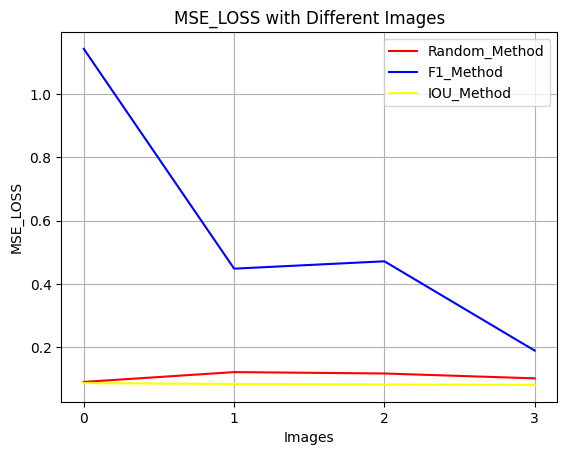

In [36]:
plot_func(random_mse_loss, f1_mse_loss, iou_mse_loss, "MSE_LOSS", x)

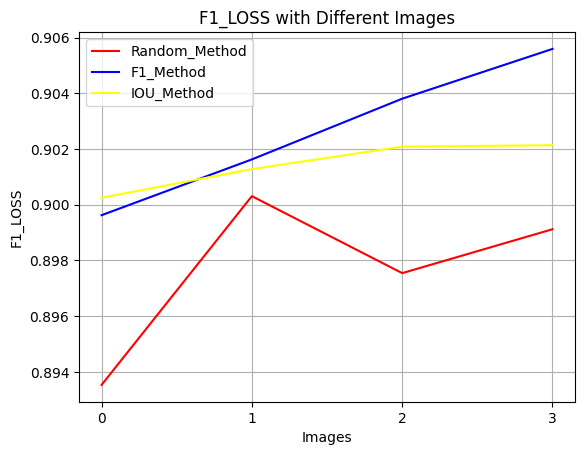

In [37]:
plot_func(random_f1_loss, f1_f1_loss, iou_f1_loss, "F1_LOSS", x)

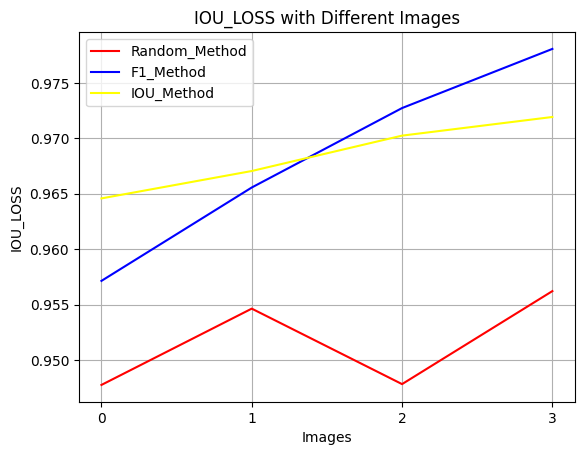

In [38]:
plot_func(random_iou_loss, f1_iou_loss, iou_iou_loss, "IOU_LOSS", x)